# Задача
На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

Метрика качества

F1-score (sklearn.metrics.f1_score)

Требования к решению

Целевая метрика

F1( 𝛽  = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
Решение должно содержать

Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv
Рекомендации для файла с кодом (ipynb)

Файл должен содержать заголовки и комментарии (markdown)
Повторяющиеся операции лучше оформлять в виде функций
Не делать вывод большого количества строк таблиц (5-10 достаточно)
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

In [152]:
import warnings
warnings.simplefilter('ignore')

In [153]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve

# Алгоритмы кластеризации 

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Метрика F1:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# для статистики
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import probplot

In [154]:
df = pd.read_csv(r'course_project_train.csv')
df_test = pd.read_csv(r'course_project_test.csv')

In [155]:
df['ID'] = df.index.tolist()

In [156]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4


In [157]:
df.shape

(7500, 18)

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [159]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.00,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.00,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.50,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.50,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.00,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.00,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.00,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.50,209323.0,360406.25,6.506797e+06


In [160]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

In [161]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [162]:
def missing_dataframe_column_values(df):
    '''Функция считает и выводит пропущенные значения столбцов датафрейма'''
    mis_val = df.isnull().sum()
    perc_mis_val = 100 * df.isnull().sum() / len(df)
    report = pd.concat([mis_val, perc_mis_val], axis=1)
    report_columns = report.rename(columns = {0: 'Пропущенные значения', 1: '% от всех значений'})
    report_columns = report_columns[report_columns.iloc[:,1] != 0].sort_values('% от всех значений', ascending=False).round(1)
    print('Датафрейм имеет ' + str(df.shape[1]) + ' столбцов.\n' + str(report_columns.shape[0]) + ' столбцов имеют пропущенные значения')
    return report_columns

In [163]:
missing_dataframe_column_values(df)

Датафрейм имеет 18 столбцов.
5 столбцов имеют пропущенные значения


,Пропущенные значения,% от всех значений
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


In [164]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

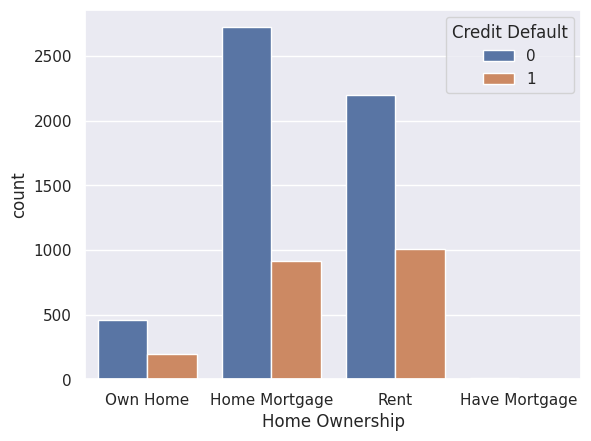

In [165]:
sns.countplot(x="Home Ownership", hue='Credit Default', data=df)
plt.show()

In [166]:
df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='Home Ownership')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)

In [167]:
df['Annual Income'].describe()#годовой доход

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [168]:
def qq_plot(target_name):
    plt.figure(figsize=(20,8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    df[target_name].hist()
    plt.subplot(122)
    probplot(df[target_name],dist='norm',plot=plt)
   
    
    plt.show()

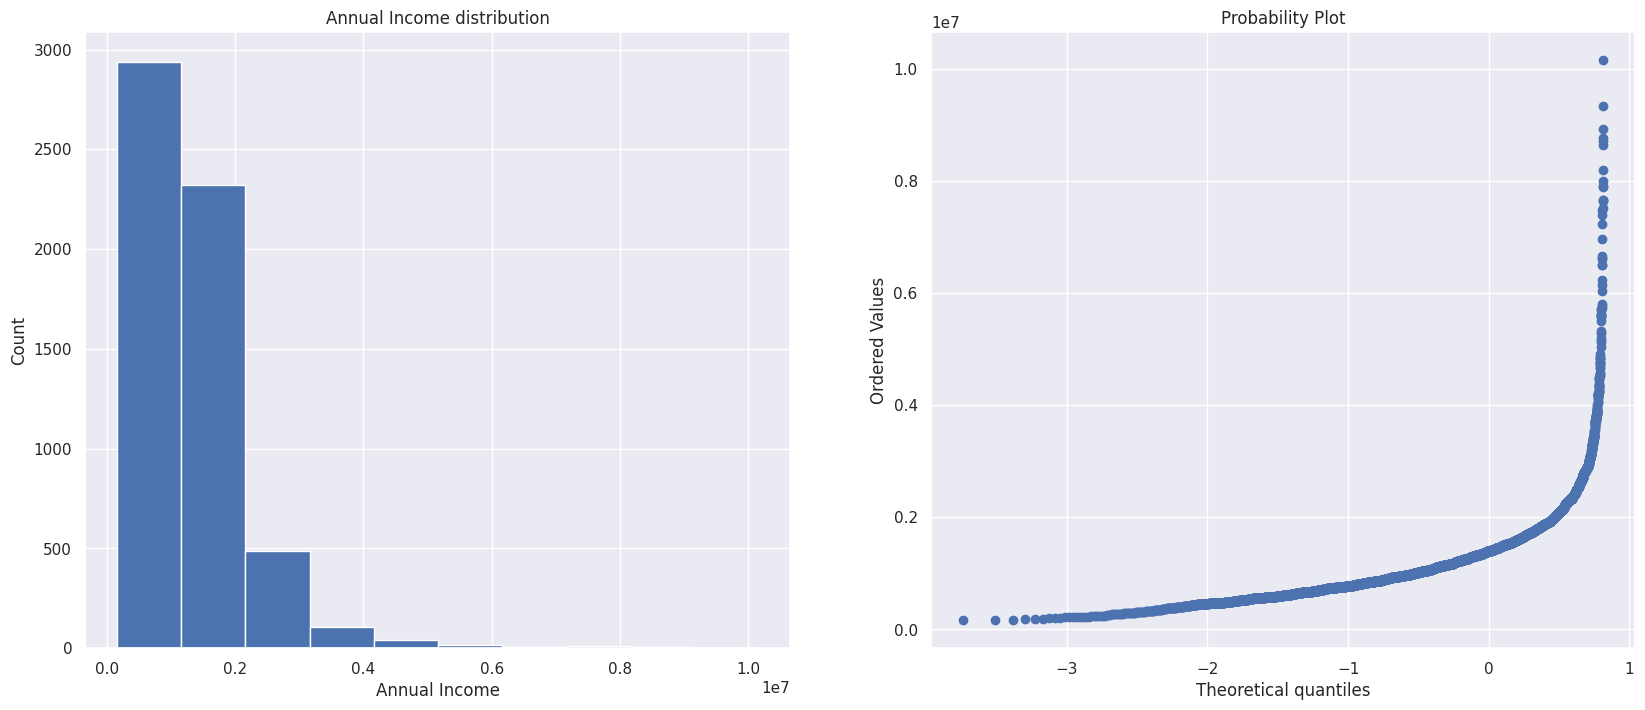

In [169]:
qq_plot('Annual Income')

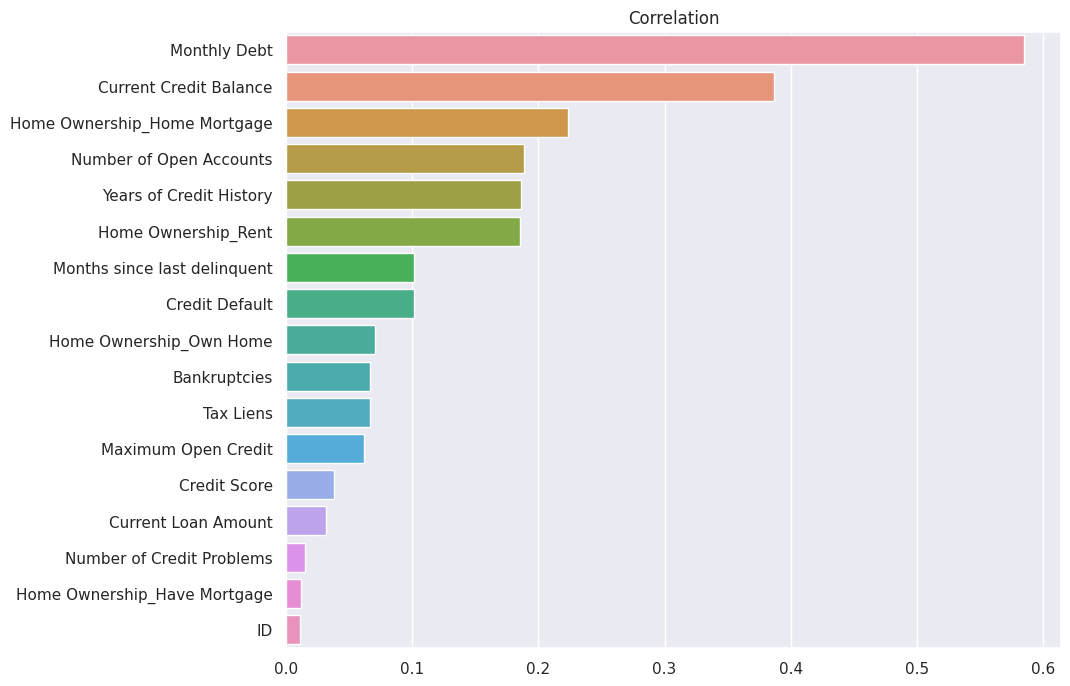

In [170]:
#как коррелируют признаки
FEATURE_NAMES = df.columns.drop('Annual Income').tolist()
corr_Annual_Income = df[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')
plt.show()

In [171]:
#  выбираем 7 наиболее  признаков 
TARGET_FEATURE = list(corr_Annual_Income.index[0:6])

In [172]:
#  набор данных для обучения
data = df.loc[(df['Annual Income'].notnull()), TARGET_FEATURE + ['Annual Income']]
data

,Monthly Debt,Current Credit Balance,Home Ownership_Home Mortgage,Number of Open Accounts,Years of Credit History,Home Ownership_Rent,Annual Income
0,7914.0,47386.0,0,11.0,26.3,0,482087.0
1,18373.0,394972.0,0,15.0,15.3,0,1025487.0
2,13651.0,308389.0,1,11.0,35.0,0,751412.0
3,11338.0,95855.0,0,8.0,22.5,0,805068.0
4,7180.0,93309.0,0,13.0,13.6,1,776264.0
...,...,...,...,...,...,...,...
7491,61150.0,108889.0,1,18.0,21.3,0,2833185.0
7493,27562.0,167428.0,0,14.0,16.5,1,1257610.0
7495,1900.0,73492.0,0,3.0,8.5,1,402192.0
7496,12783.0,456399.0,1,10.0,26.5,0,1533984.0


In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Monthly Debt                  5943 non-null   float64
 1   Current Credit Balance        5943 non-null   float64
 2   Home Ownership_Home Mortgage  5943 non-null   uint8  
 3   Number of Open Accounts       5943 non-null   float64
 4   Years of Credit History       5943 non-null   float64
 5   Home Ownership_Rent           5943 non-null   uint8  
 6   Annual Income                 5943 non-null   float64
dtypes: float64(5), uint8(2)
memory usage: 290.2 KB


In [174]:
%%time

# обучение на Регрессии

model_Annual_Income = LogisticRegression()
model_Annual_Income.fit(data[TARGET_FEATURE], data['Annual Income'])

CPU times: user 1min 51s, sys: 44.7 s, total: 2min 36s
Wall time: 1min 57s


LogisticRegression()

In [175]:
# заполним пропуски

df.loc[(df['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df.loc[(df['Annual Income'].isnull()), TARGET_FEATURE])

df_test.loc[(df_test['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df_test.loc[(df_test['Annual Income'].isnull()), TARGET_FEATURE])

In [176]:
shapiro(df['Annual Income'])

ShapiroResult(statistic=0.7563977837562561, pvalue=0.0)

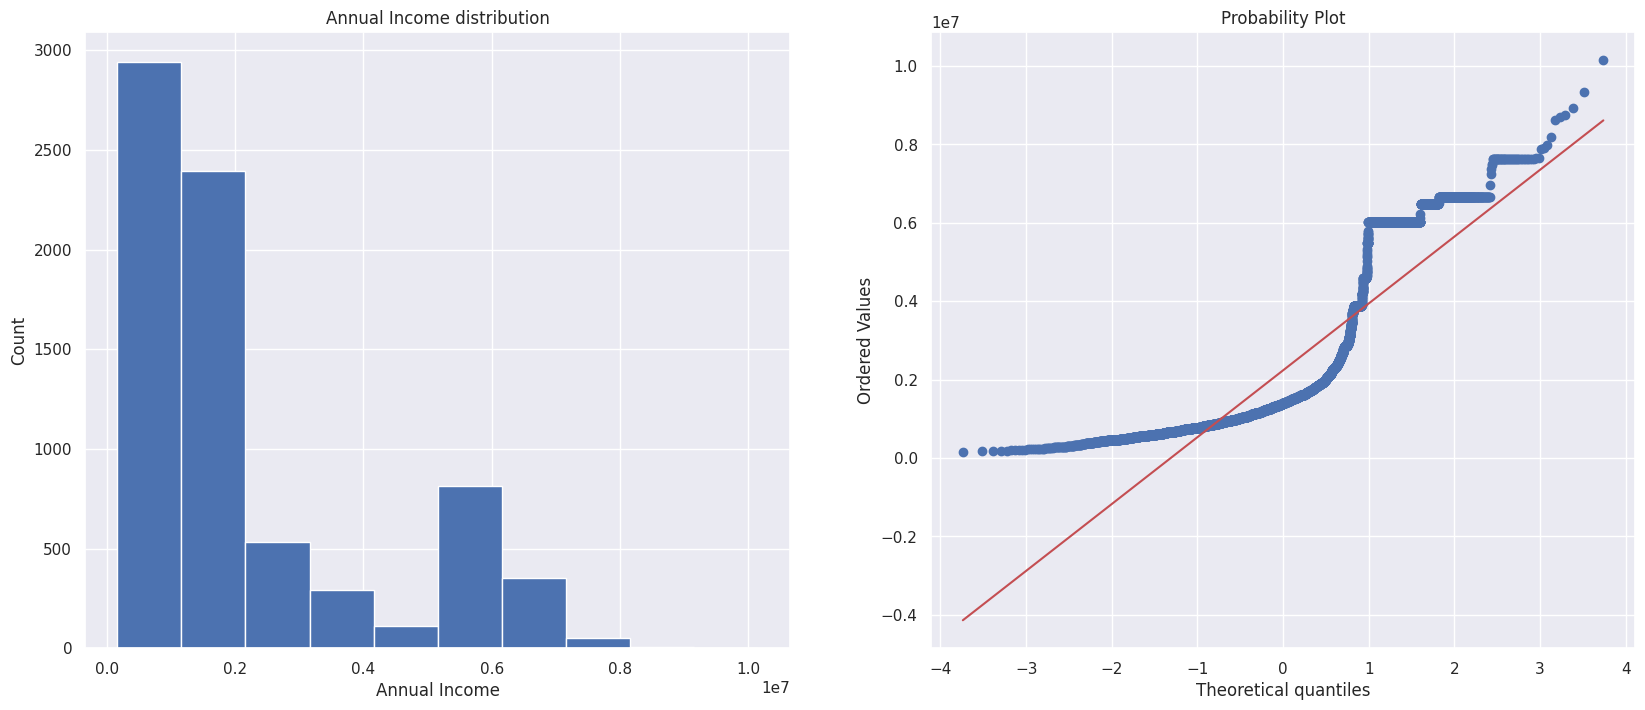

In [177]:
qq_plot('Annual Income')

In [178]:
Annual_Income_with_target_s = df[['Annual Income', 'Credit Default']]
Annual_Income_target_0 = df.loc[df['Credit Default'] == 0, ['Annual Income']]
Annual_Income_target_1 = df.loc[df['Credit Default'] == 1, ['Annual Income']]

In [179]:
mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)#U-критерий Манна — Уитни  — статистический критерий, используемый для оценки различий между двумя независимыми выборками по уровню какого-либо признака, измеренного количественно. Позволяет выявлять различия в значении параметра между малыми выборками.

MannwhitneyuResult(statistic=array([5896420.5]), pvalue=array([0.01499816]))

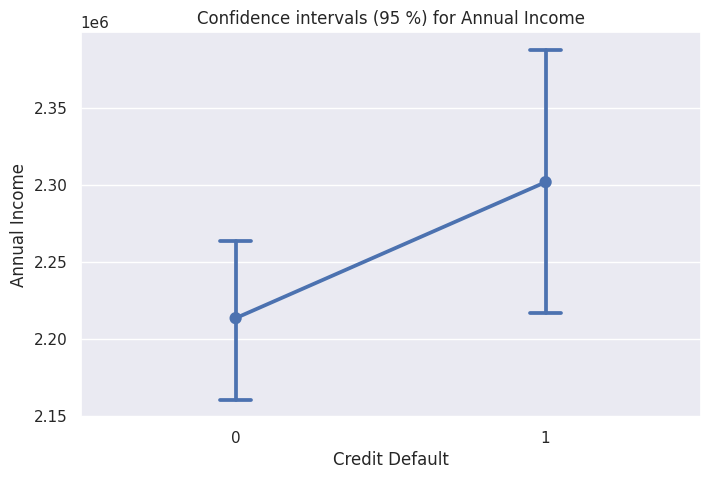

In [180]:
plt.figure(figsize=(8,5))

sns.pointplot(x='Credit Default', y='Annual Income', data=Annual_Income_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')

plt.show()

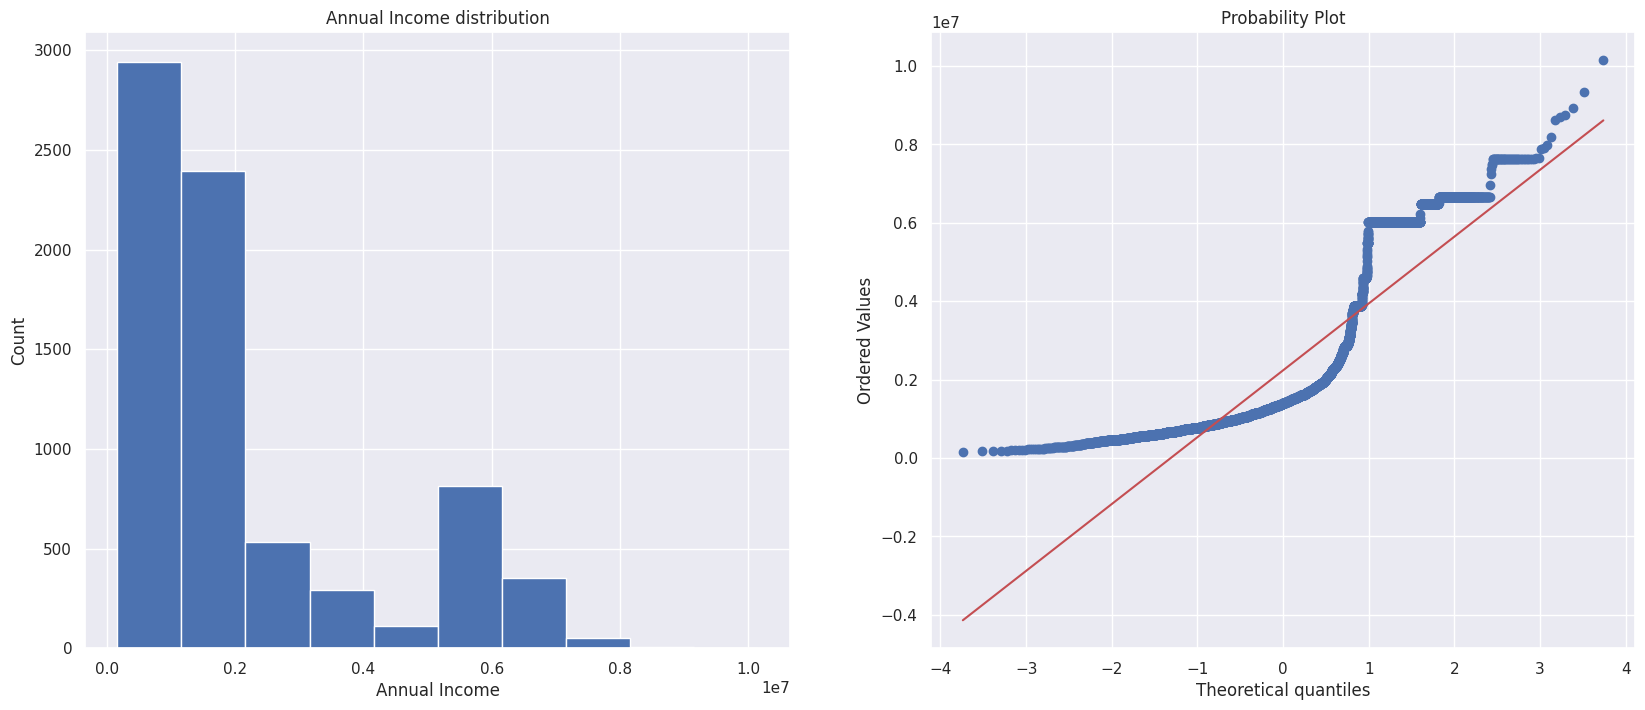

In [181]:
qq_plot('Annual Income')

In [182]:
# обрежим

df.loc[df['Annual Income'] > df['Annual Income'].quantile(.99), ['Annual Income']] =\
            df['Annual Income'].quantile(.99)  #df['Annual Income'].median()

df_test.loc[df_test['Annual Income'] > df_test['Annual Income'].quantile(.99), ['Annual Income']] = \
            df_test['Annual Income'].quantile(.99) #df_test['Annual Income'].median()

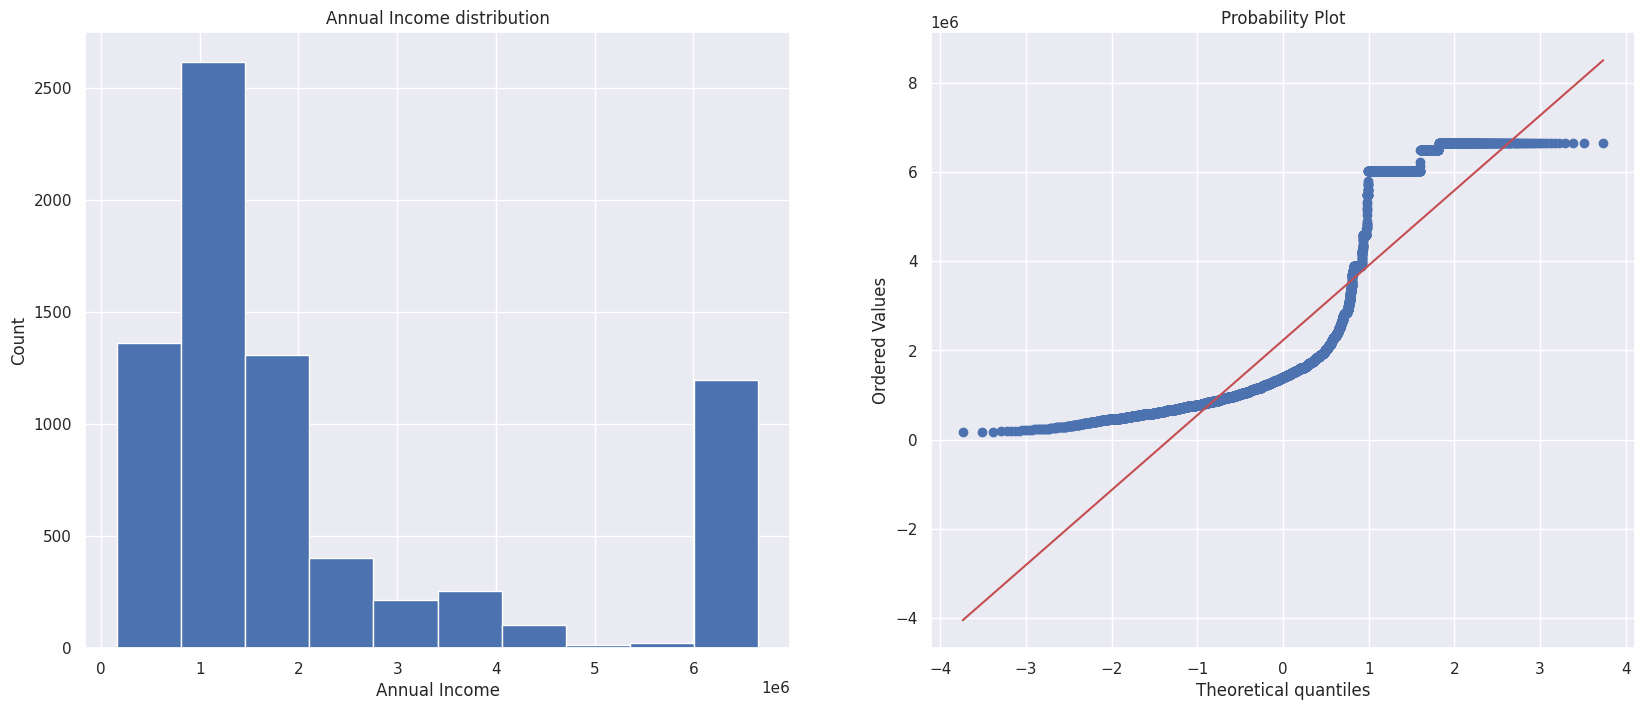

In [183]:
qq_plot('Annual Income')

In [184]:
df['Years in current job'].value_counts()#количество лет на текущем месте работы

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

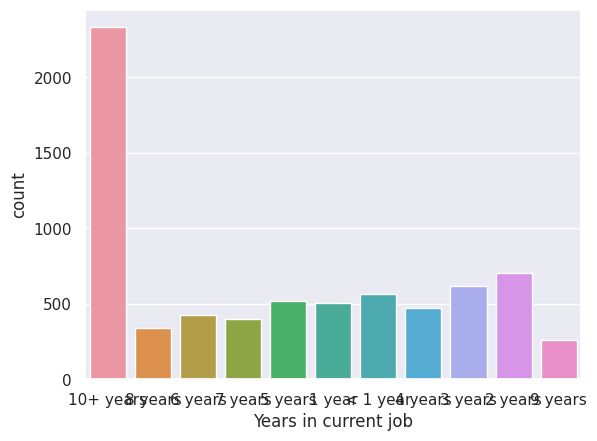

In [185]:
sns.countplot(x="Years in current job", data=df)
plt.show()

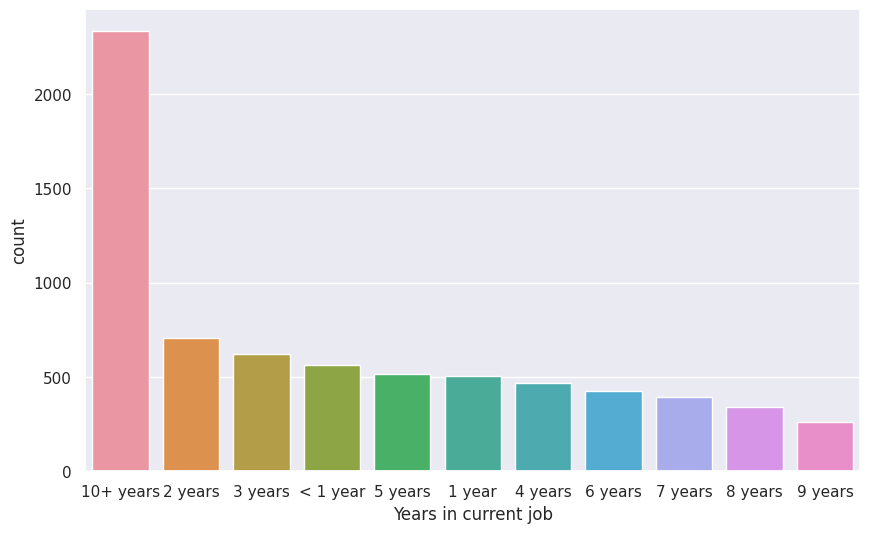

In [186]:
#распределение от стажа 
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
sns.countplot(x="Years in current job", data=df, order = df['Years in current job'].value_counts().index)
plt.show()

In [187]:
df['Years in current job'] = df['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 11



df_test['Years in current job'] = df_test['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 11

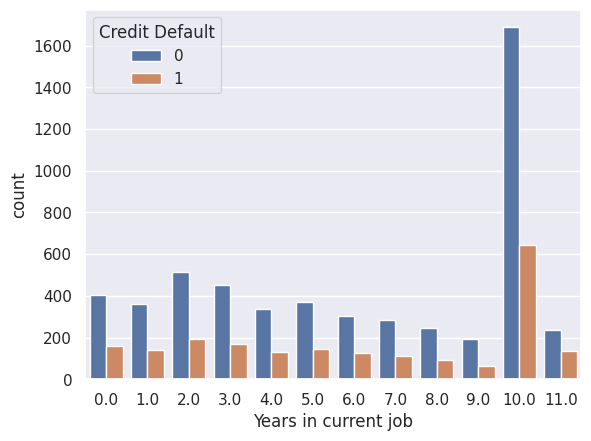

In [188]:
sns.countplot(x="Years in current job", hue='Credit Default', data=df)
plt.show()

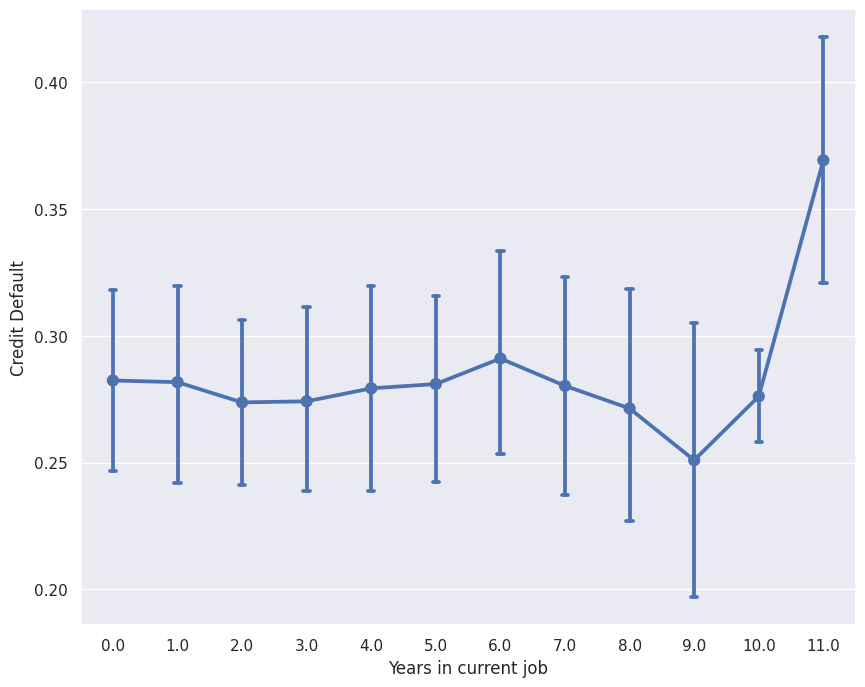

In [189]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Years in current job', y='Credit Default', data=df, capsize=.1,);

In [190]:
df['Tax Liens'].value_counts()#налоговые обременения

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

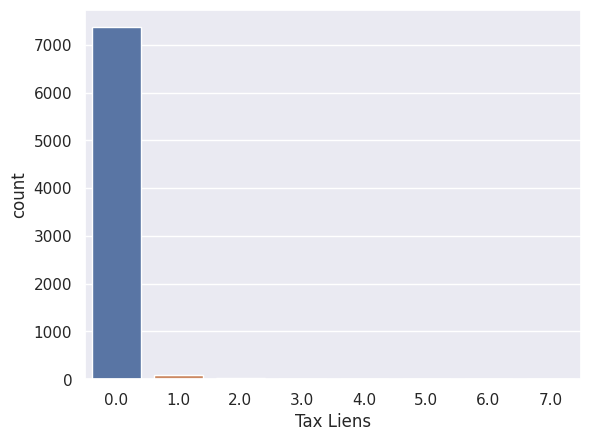

In [191]:
sns.countplot(x="Tax Liens", data=df)
plt.show()

In [192]:
df['Number of Open Accounts'].describe()#количество открытых счетов

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

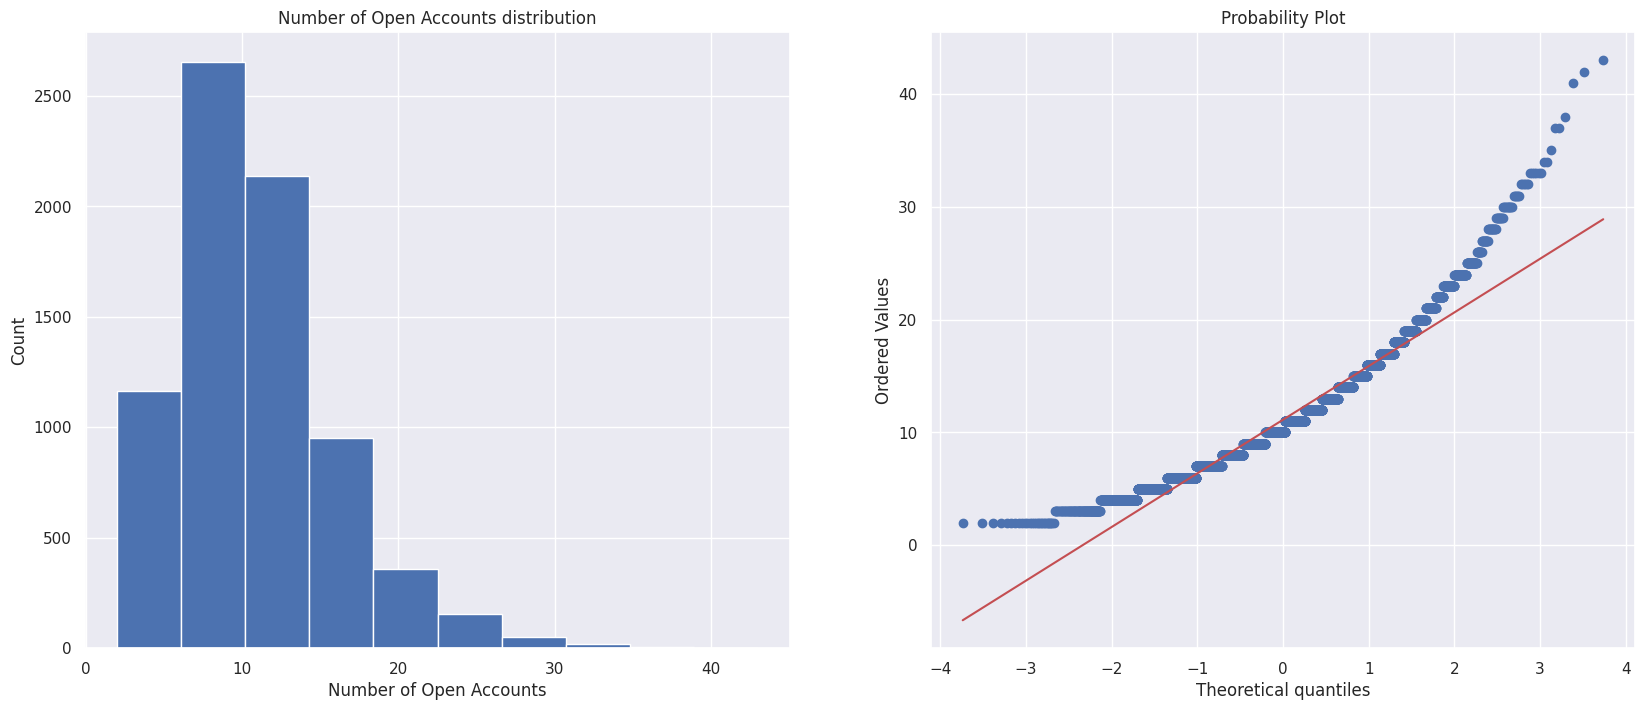

In [193]:
qq_plot('Number of Open Accounts')

In [194]:
df.loc[(df['Number of Open Accounts'] > df['Number of Open Accounts'].quantile(.90)), :].shape

(731, 22)

In [195]:
df.loc[df['Number of Open Accounts'] > df['Number of Open Accounts'].quantile(.90), ['Number of Open Accounts']] =\
            df['Number of Open Accounts'].median()

df_test.loc[df_test['Number of Open Accounts'] > df_test['Number of Open Accounts'].quantile(.90),  \
            ['Number of Open Accounts']] = df_test['Number of Open Accounts'].median()

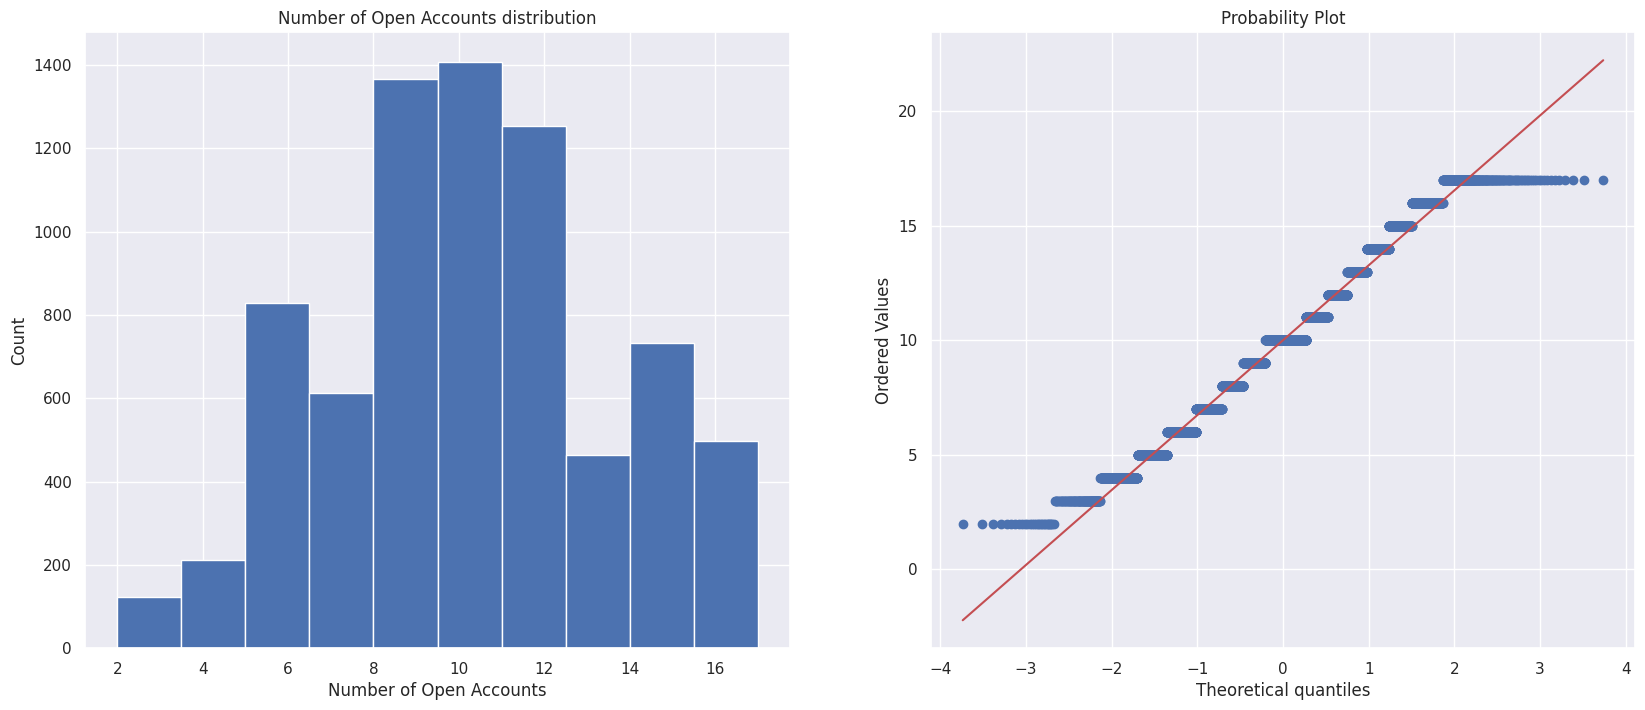

In [196]:
qq_plot('Number of Open Accounts')

In [197]:
df['Years of Credit History'].value_counts()#количество лет кредитной истори

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
44.0      1
39.8      1
40.0      1
39.9      1
48.3      1
Name: Years of Credit History, Length: 408, dtype: int64

<Axes: >

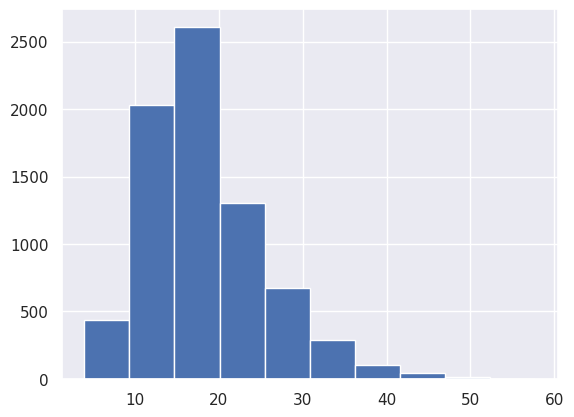

In [198]:
df['Years of Credit History'].hist()

In [199]:

# все, что больше 30 - заменяем на 30

df.loc[df['Years of Credit History'] > 30, ['Years of Credit History']] = 30

df_test.loc[df_test['Years of Credit History'] > 40, ['Years of Credit History']] = 30

<Axes: >

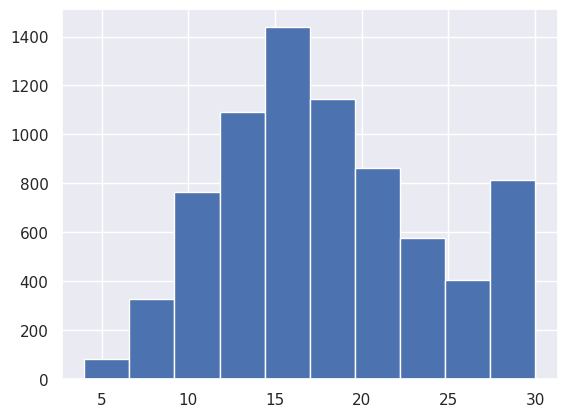

In [200]:
df['Years of Credit History'].hist()

In [201]:
df['Maximum Open Credit'].describe()#Максимальный открытый кредит

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

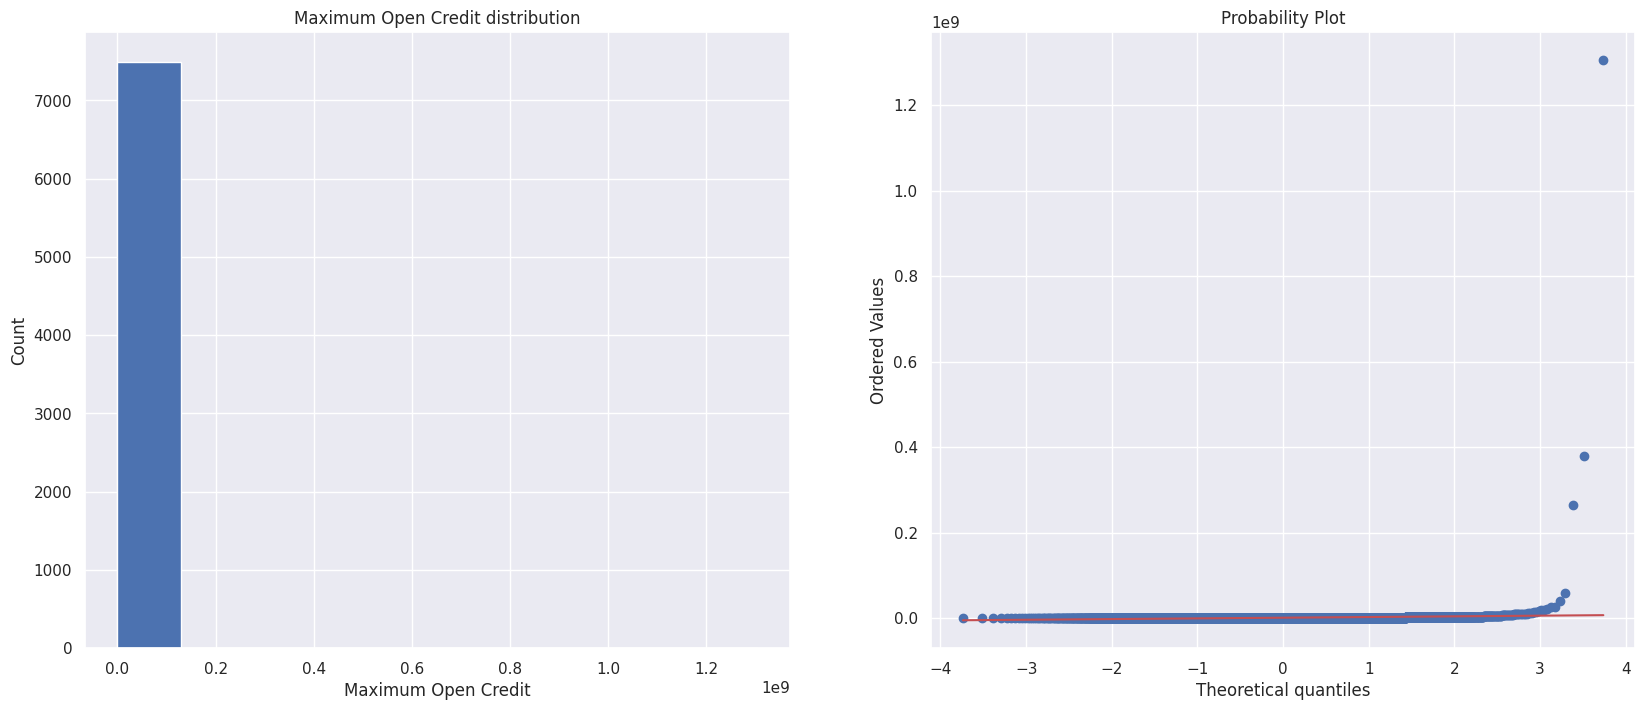

In [202]:
qq_plot('Maximum Open Credit')

In [203]:
df.loc[df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.90), ['Maximum Open Credit']] =\
            df['Maximum Open Credit'].quantile(.95)

df_test.loc[df_test['Maximum Open Credit'] > df_test['Maximum Open Credit'].quantile(.90), ['Maximum Open Credit']] =\
            df_test['Maximum Open Credit'].quantile(.90)

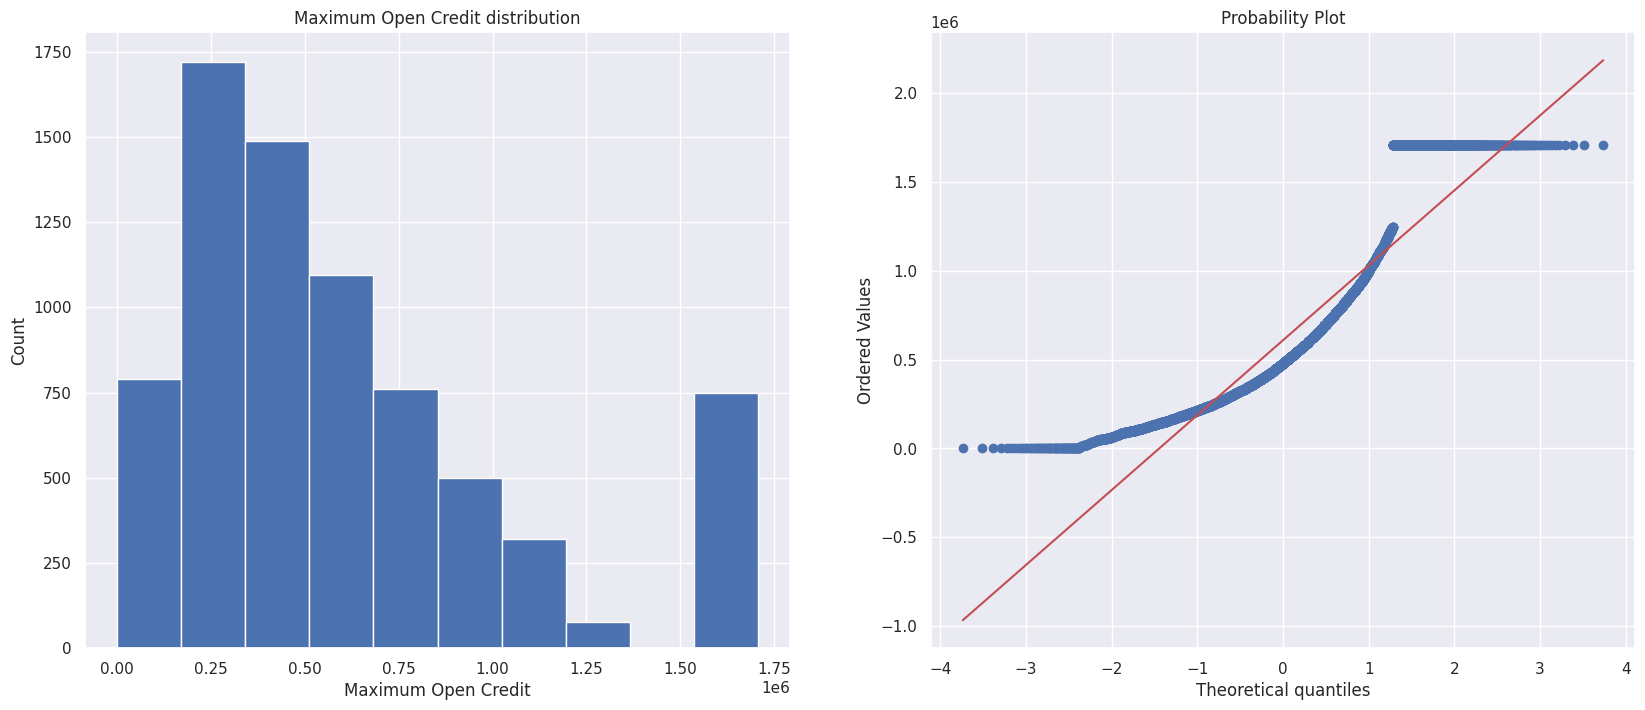

In [204]:
qq_plot('Maximum Open Credit')

In [205]:
df['Number of Credit Problems'].value_counts()# проблемы с кредитом

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [206]:
df['Bankruptcies'].value_counts()#банкротства

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [207]:
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

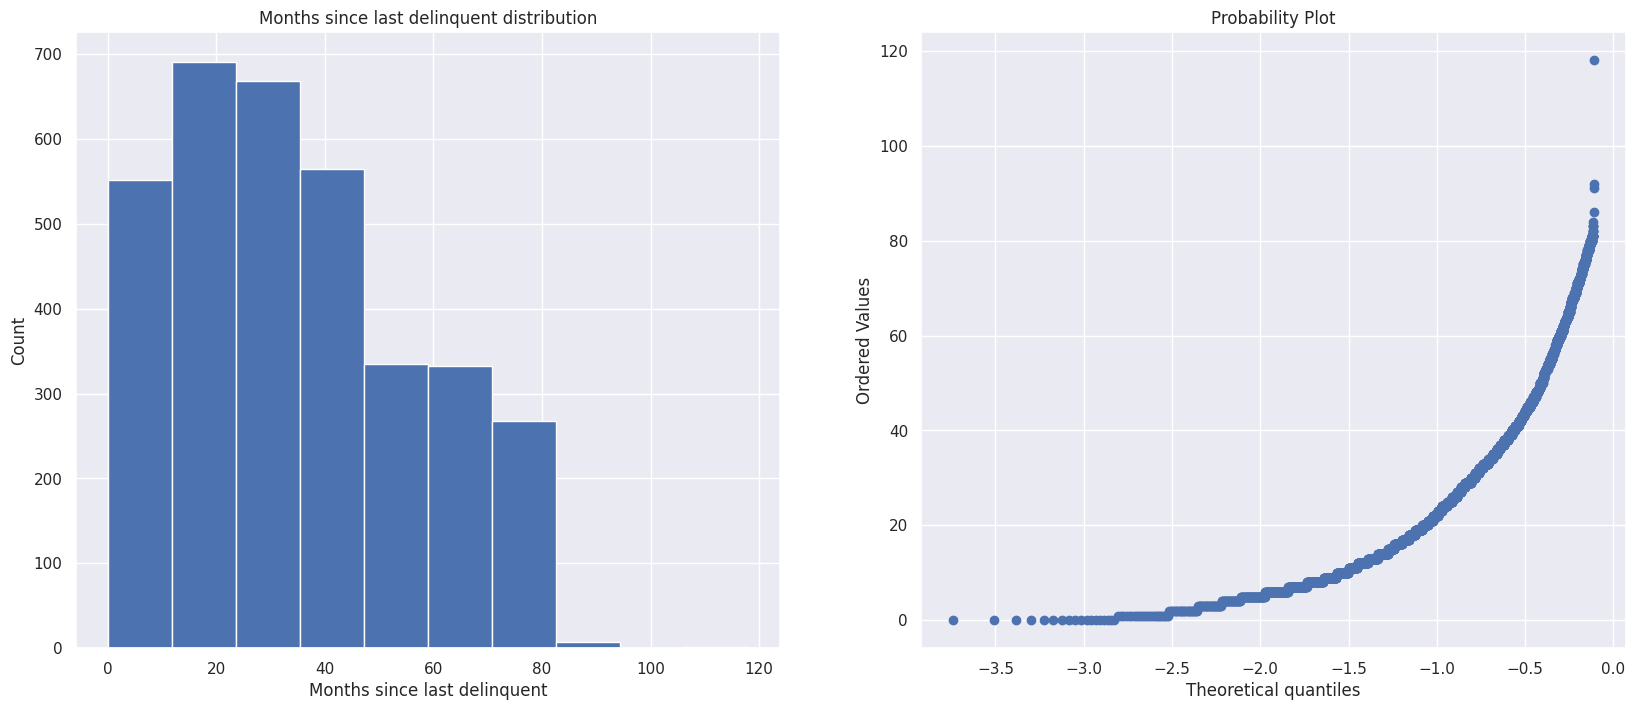

In [208]:
qq_plot('Months since last delinquent')#оличество месяцев с последней просрочки кредита

In [209]:
df['Months since last delinquent NULL'] = df['Months since last delinquent'].isnull()
df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0


df_test['Months since last delinquent NULL'] = df_test['Months since last delinquent'].isnull()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

In [210]:
df['Purpose'].value_counts()#цель кредита

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [211]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

<Axes: title={'center': 'Purpose'}>

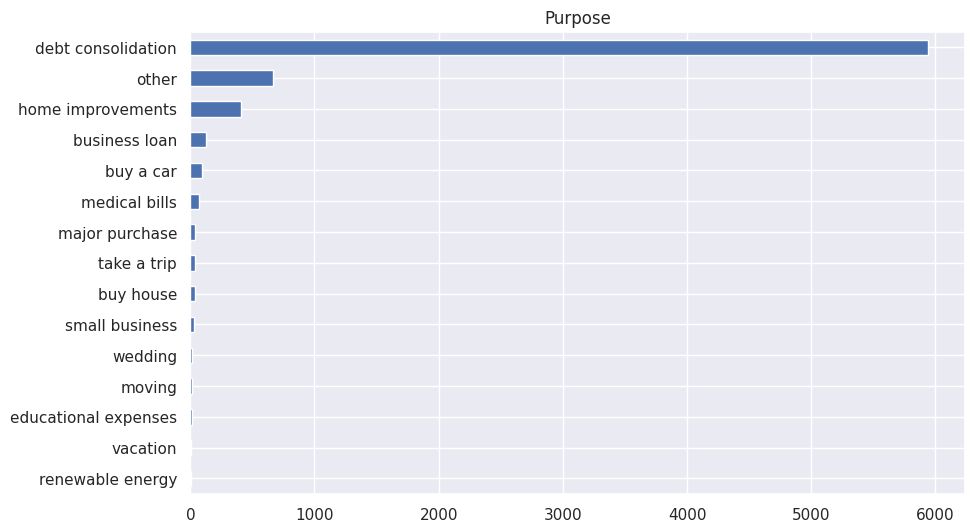

In [212]:
df['Purpose'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Purpose', figsize=(10,6))

<Axes: title={'center': 'Purpose / Credit Default'}, xlabel='Purpose'>

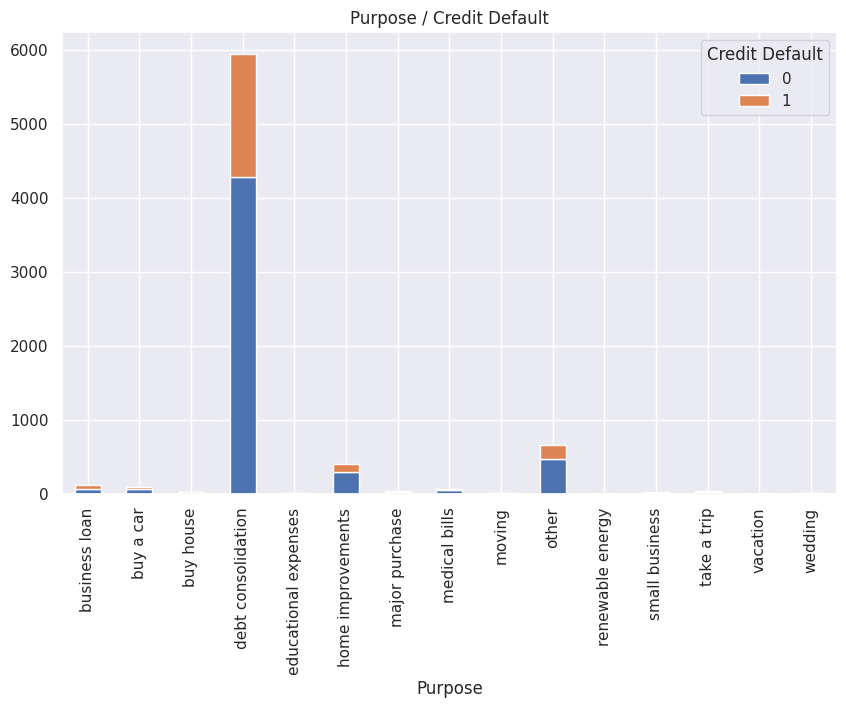

In [213]:
purpose_deafult = df[['Purpose','Credit Default']]
pd.crosstab(purpose_deafult['Purpose'], purpose_deafult['Credit Default']).plot \
(kind='bar', stacked=True, figsize=(10,6), title="Purpose / Credit Default", )

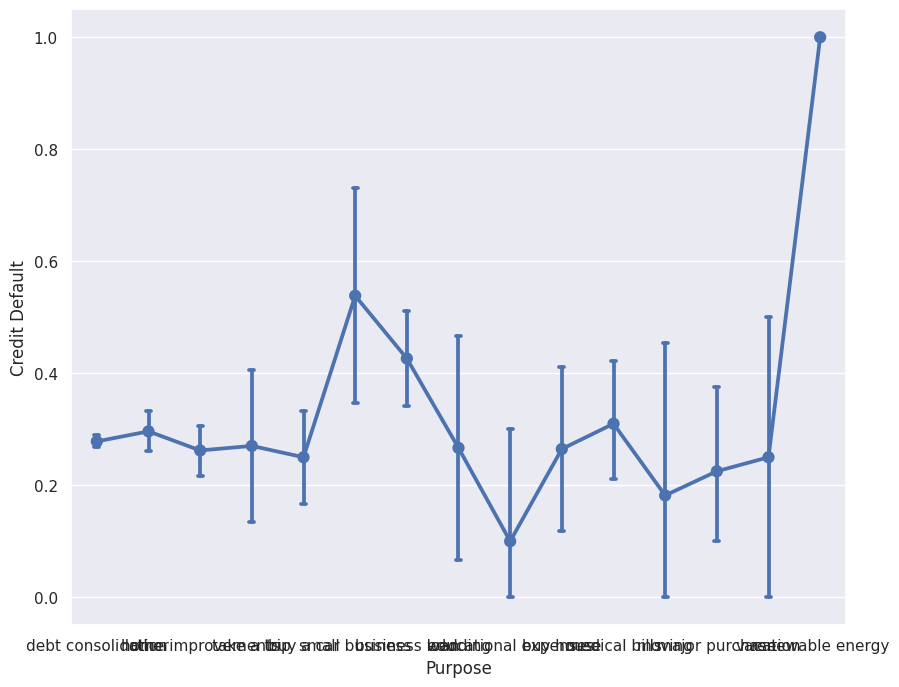

In [214]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Purpose', y='Credit Default', data=df, capsize=.1,);

In [215]:
#   хватит  4 категории

df['Purpose'] = df['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

In [216]:
df_test['Purpose'] = df_test['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

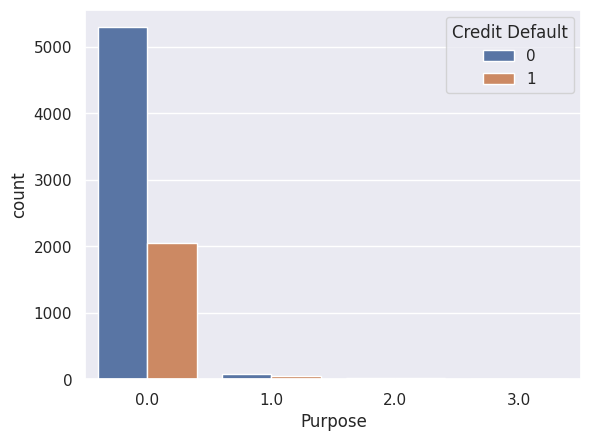

In [217]:
sns.countplot(x="Purpose", hue='Credit Default', data=df)
plt.show()

In [218]:
df['Term'].value_counts()#срок кредита

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [219]:
df['Term'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)
df_test['Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)

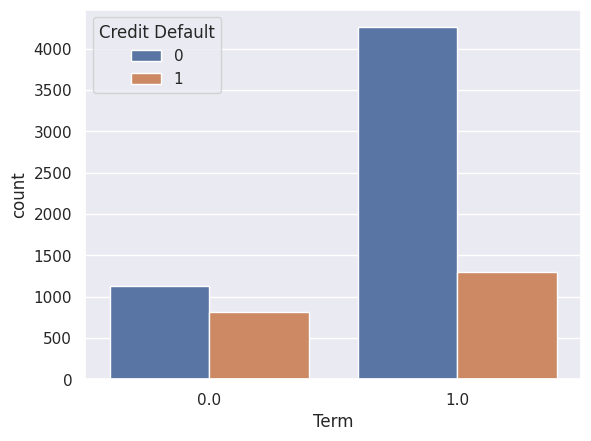

In [220]:
sns.countplot(x="Term", hue='Credit Default', data=df)
plt.show()

In [221]:
# функция показывает корреляцию мжду двумя группами одного признака в отношении целевого признака. 

def corr_(val, x1, x2):
    pay1_and_target_s = df.loc[df[val].isin([x1, x2]), ['ID', val, 'Credit Default']]#.sample(1000)
    table = pay1_and_target_s.pivot_table(values='ID', index=val, columns='Credit Default', aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)

In [222]:
corr_('Term',0,1)

In [223]:
df['Current Loan Amount'].value_counts()#текущая сумма кредита

99999999.0    870
218064.0        6
89298.0         6
222926.0        5
265826.0        5
             ... 
351626.0        1
212498.0        1
187682.0        1
108922.0        1
26928.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [224]:
df['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

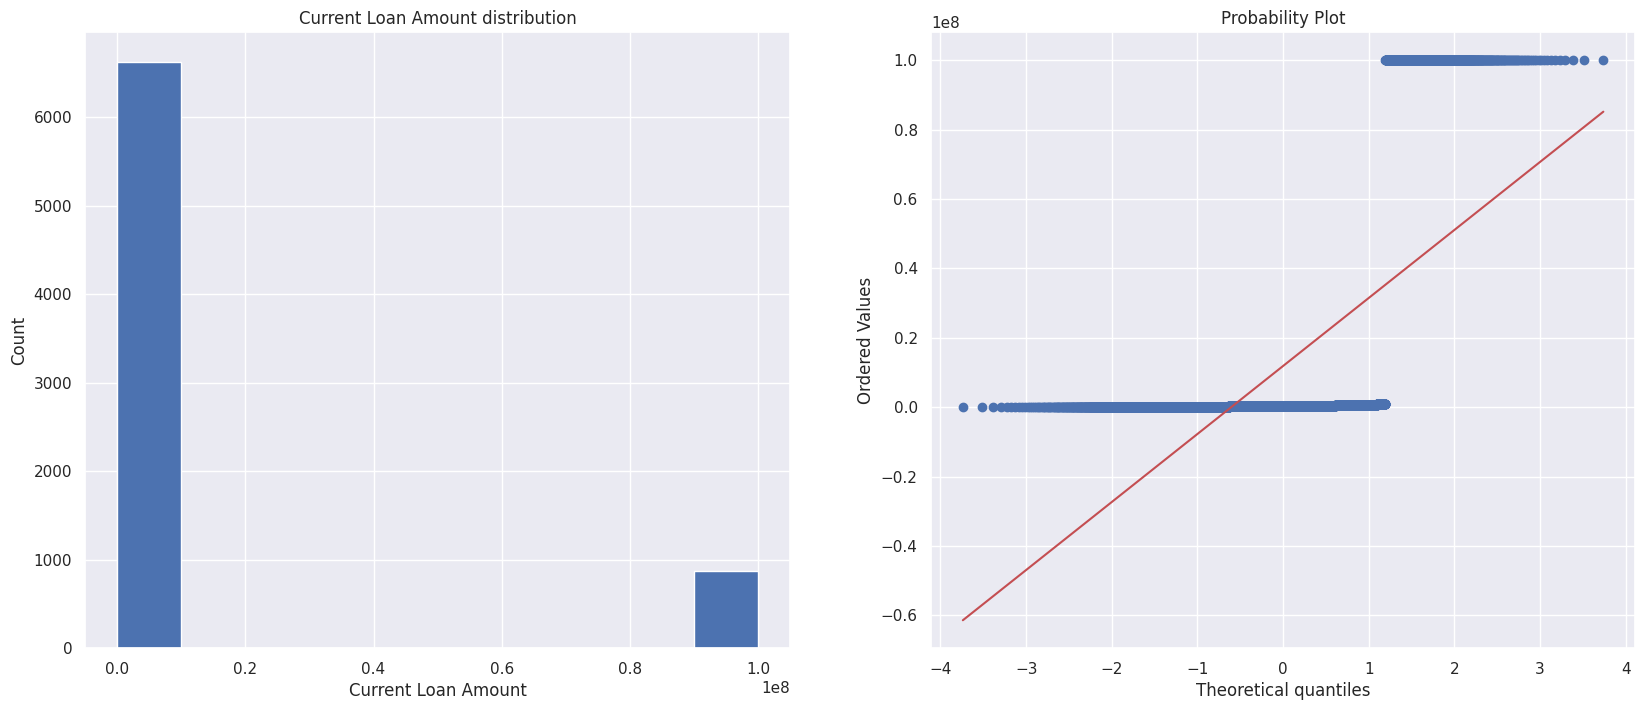

In [225]:
qq_plot('Current Loan Amount')

In [226]:
# вынос больших выбросов в отдельную переменную

df['Current Loan Amount BIG'] = df['Current Loan Amount'] == 99999999
df_test['Current Loan Amount BIG'] = df_test['Current Loan Amount'] == 99999999

In [227]:
df.loc[df['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None
df_test.loc[df_test['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None

In [228]:
#train_df.loc[train_df['Annual Income'].isna(), 'Annual Income'] = train_df['Annual Income'].median()
#train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = train_df['Months since last delinquent'].median()
#train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = train_df['Credit Score'].median()

In [229]:
df.loc[df['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df['Current Loan Amount'].mean() #median()
df_test.loc[df_test['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df_test['Current Loan Amount'].mean() #median()


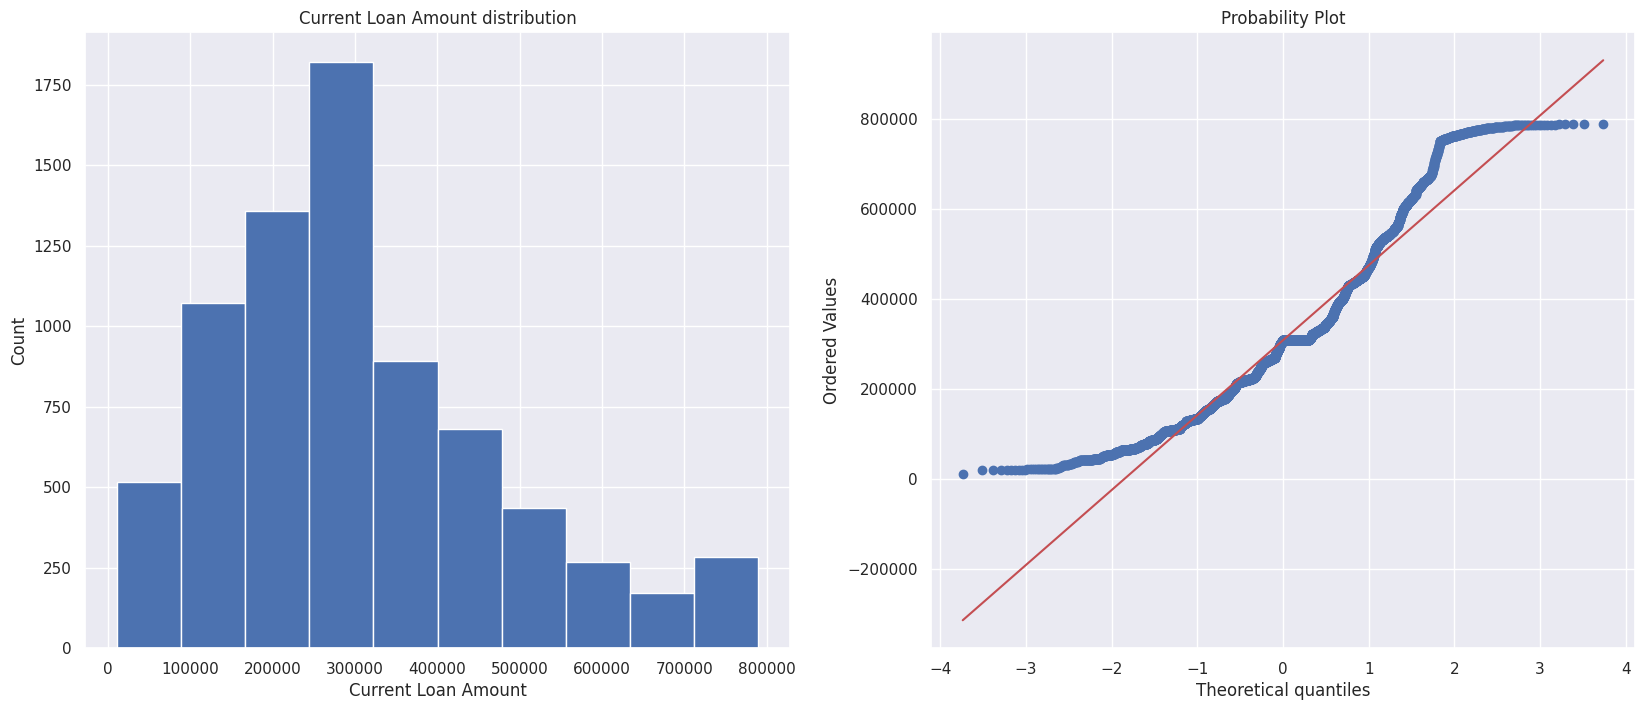

In [230]:
qq_plot('Current Loan Amount')

In [231]:
df['Current Credit Balance'].describe()#текущий кредитный баланс

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

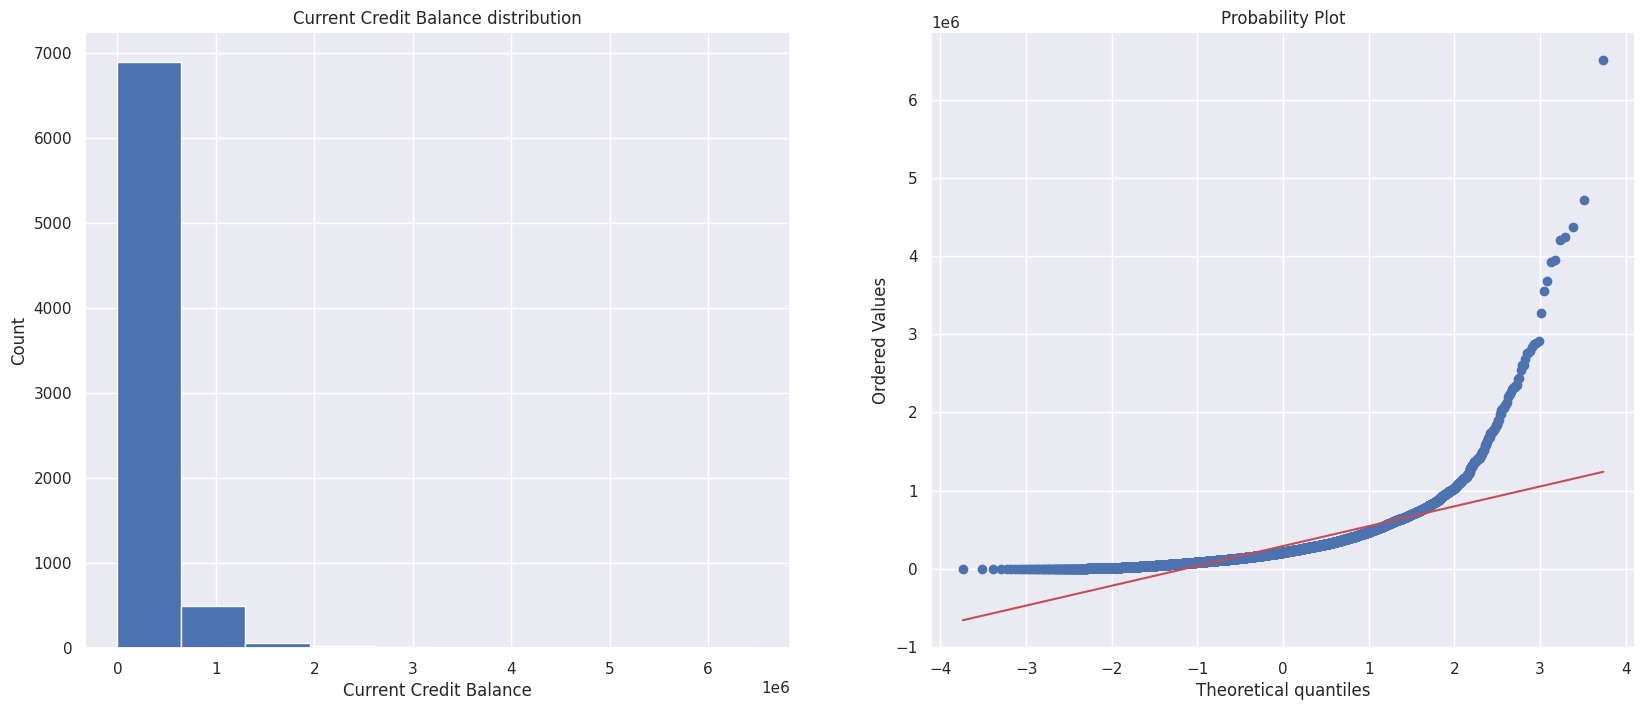

In [232]:
qq_plot('Current Credit Balance')

In [233]:
# выбросы

df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.90), :].shape

(750, 24)

In [234]:
df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.90), \
       ['Current Credit Balance']] = df['Current Credit Balance'].quantile(.90) #df['Current Credit Balance'].mean()

df_test.loc[df_test['Current Credit Balance'] > df_test['Current Credit Balance'].quantile(.90), \
       ['Current Credit Balance']] = df_test['Current Credit Balance'].quantile(.90) #df_test['Current Credit Balance'].mean()

In [235]:
df['Monthly Debt'].value_counts()#ежемесячный долг

0.0        6
19222.0    4
19667.0    4
12986.0    3
13356.0    3
          ..
33217.0    1
8203.0     1
15150.0    1
1992.0     1
9061.0     1
Name: Monthly Debt, Length: 6716, dtype: int64

<Axes: >

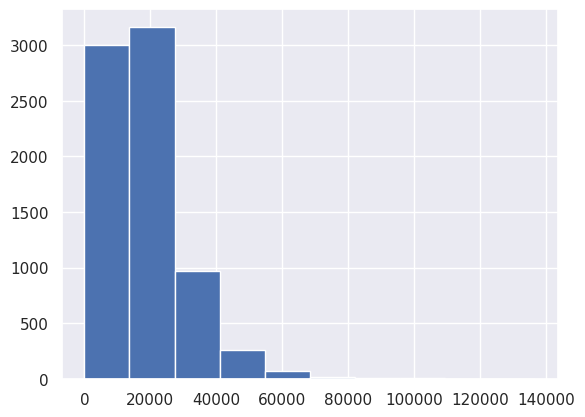

In [236]:
df['Monthly Debt'].hist()

In [237]:
df.loc[df['Monthly Debt'] > df['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df['Monthly Debt'].mean()

df_test.loc[df_test['Monthly Debt'] > df_test['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df_test['Monthly Debt'].mean()

<Axes: >

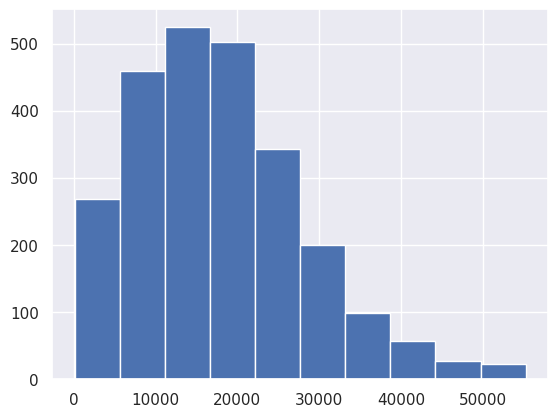

In [238]:
df_test['Monthly Debt'].hist()

In [239]:
df['Credit Score'].describe()#кредитный рейтинг

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

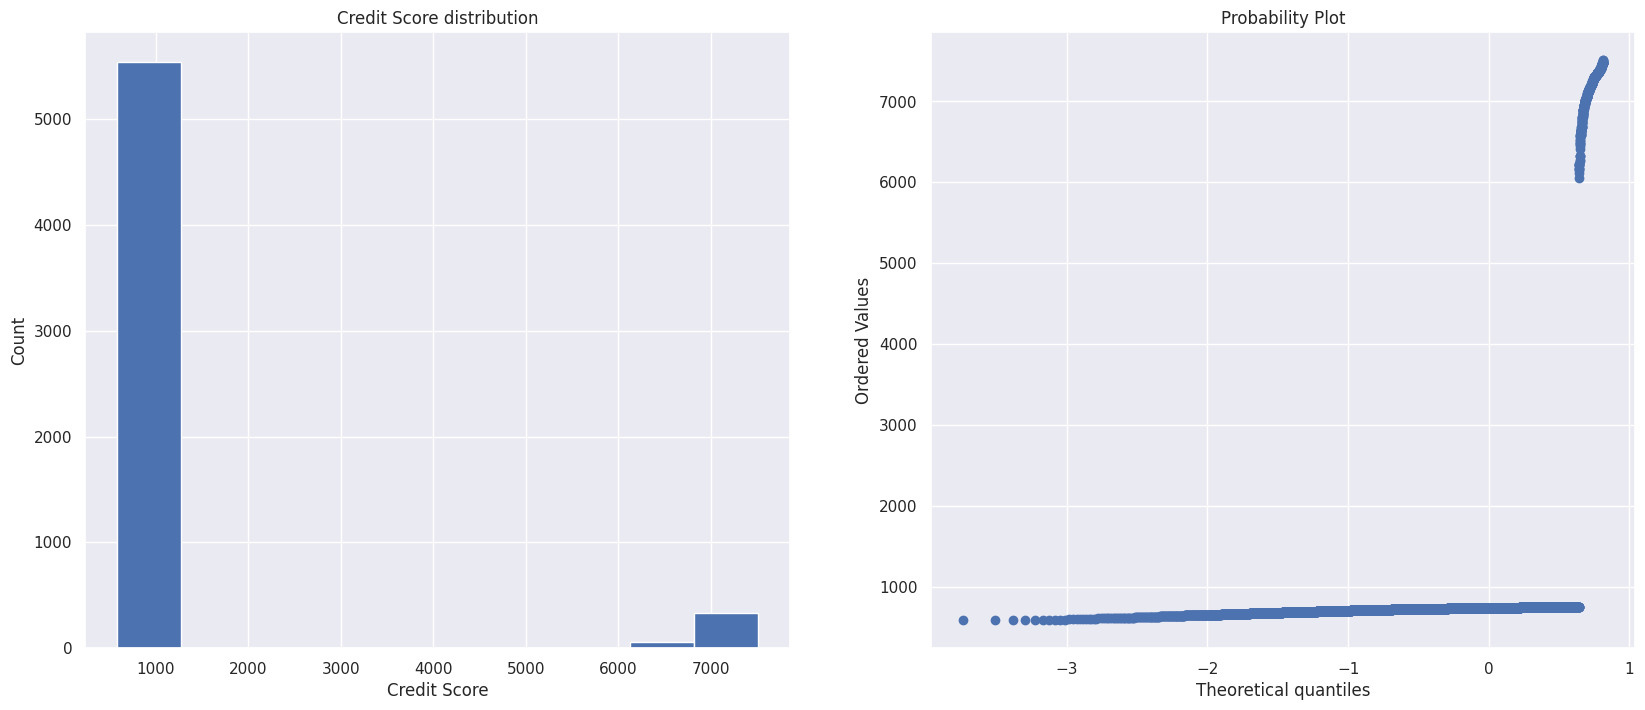

In [240]:
qq_plot('Credit Score')

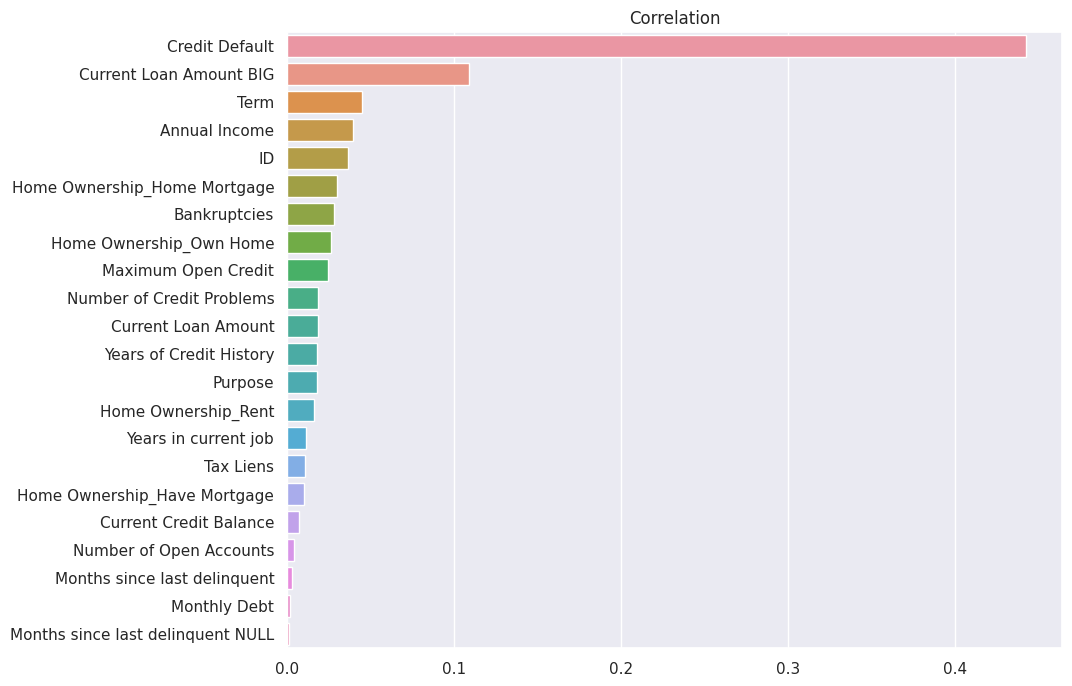

In [241]:
FEATURE_NAMES = df.columns.drop('Credit Score').tolist()
corr_Credit_Score = df[FEATURE_NAMES + ['Credit Score']].corr().iloc[:-1, -1]
corr_Credit_Score = np.abs(corr_Credit_Score).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Credit_Score.values, y=corr_Credit_Score.index)

plt.title('Correlation')
plt.show()

In [242]:
# для обучения выбираем 7 наиболее влияющих признаков (8-й признак сам имеет много null)


TARGET_FEATURE = [
                 
                 'Current Loan Amount BIG',
                 'Current Loan Amount',
                 'Term',
                 'Annual Income',
                 
                 'Home Ownership_Home Mortgage',
                 'Bankruptcies',
                 'Home Ownership_Own Home',
                 'Maximum Open Credit',
                 'Number of Credit Problems',
                 'Purpose',
                 'Home Ownership_Rent',
                 'Years of Credit History',
                 'Years in current job'
                 ]

In [243]:
# отбираем набор данных для обучения
data = df.loc[(df['Credit Score'].notnull()), TARGET_FEATURE + ['Credit Score']]#.sample(2000)

In [244]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Current Loan Amount BIG       5943 non-null   bool   
 1   Current Loan Amount           5943 non-null   float64
 2   Term                          5943 non-null   float64
 3   Annual Income                 5943 non-null   float64
 4   Home Ownership_Home Mortgage  5943 non-null   uint8  
 5   Bankruptcies                  5943 non-null   float64
 6   Home Ownership_Own Home       5943 non-null   uint8  
 7   Maximum Open Credit           5943 non-null   float64
 8   Number of Credit Problems     5943 non-null   float64
 9   Purpose                       5943 non-null   float64
 10  Home Ownership_Rent           5943 non-null   uint8  
 11  Years of Credit History       5943 non-null   float64
 12  Years in current job          5943 non-null   float64
 13  Cre

In [245]:
%%time

# учимся на Регрессии

model_Credit_Score = LogisticRegression()
model_Credit_Score.fit(data[TARGET_FEATURE], data['Credit Score'])

CPU times: user 7.58 s, sys: 4.61 s, total: 12.2 s
Wall time: 8.02 s


LogisticRegression()

In [246]:
# заполняем пропуски на основе обученной модели

df.loc[(df['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df.loc[(df['Credit Score'].isnull()), TARGET_FEATURE])

df_test.loc[(df_test['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df_test.loc[(df_test['Credit Score'].isnull()), TARGET_FEATURE])

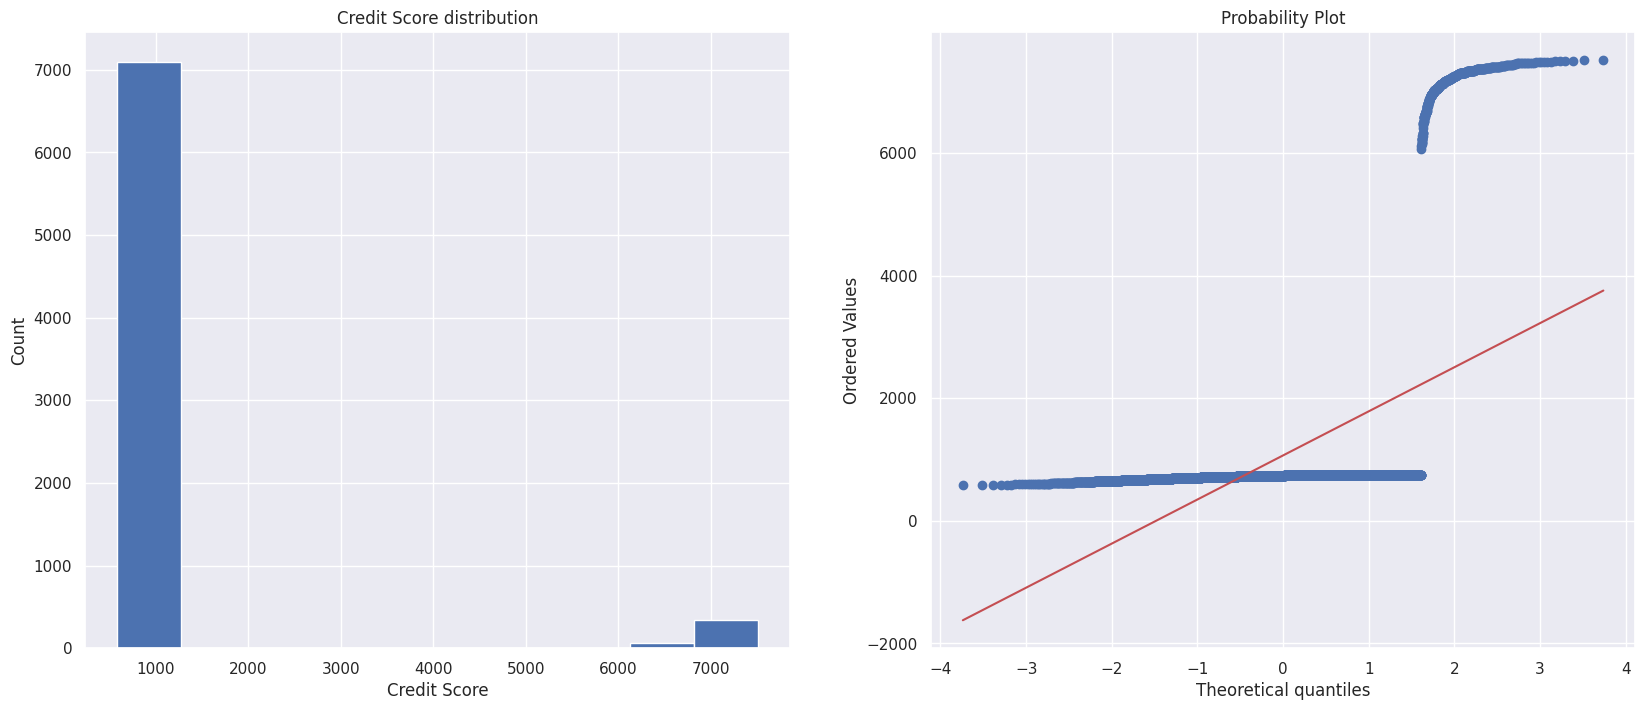

In [247]:
qq_plot('Credit Score')

In [248]:
df.loc[(df['Credit Score'] < 700), 'Credit Score'] = 0
df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 740), 'Credit Score'] = 1

df.loc[(df['Credit Score'] >= 740) & (df['Credit Score'] <= 750), 'Credit Score'] = 2
df.loc[(df['Credit Score'] >= 750) & (df['Credit Score'] <= 800), 'Credit Score'] = 3
df.loc[(df['Credit Score'] > 800), 'Credit Score'] = 4



df_test.loc[(df_test['Credit Score'] < 700), 'Credit Score'] = 0
df_test.loc[(df_test['Credit Score'] >= 700) & (df_test['Credit Score'] < 740), 'Credit Score'] = 1
df_test.loc[(df_test['Credit Score'] >= 740) & (df_test['Credit Score'] <= 750), 'Credit Score'] = 2
df_test.loc[(df_test['Credit Score'] >= 750) & (df_test['Credit Score'] <= 800), 'Credit Score'] = 3
df_test.loc[(df_test['Credit Score'] > 800), 'Credit Score'] = 4


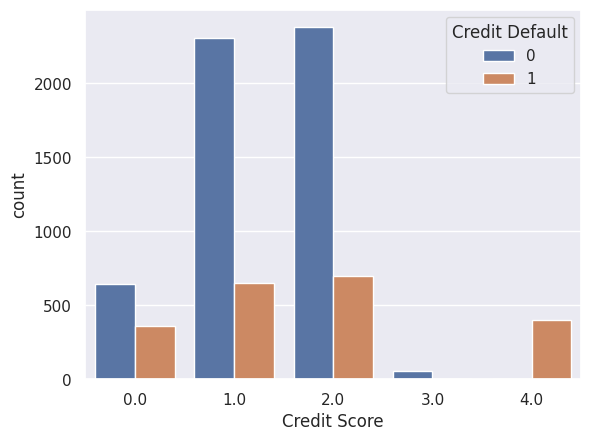

In [249]:
sns.countplot(x="Credit Score", hue='Credit Default', data=df)
plt.show()

In [250]:
df['Good'] = (df['Tax Liens'] == 0) & (df['Bankruptcies'] == 0) & (df['Number of Credit Problems'] == 0)#Новый признак
df_test['Good'] = (df_test['Number of Credit Problems'] == 0) \
                                & (df_test['Bankruptcies'] == 0) & (df_test['Tax Liens'] == 0)

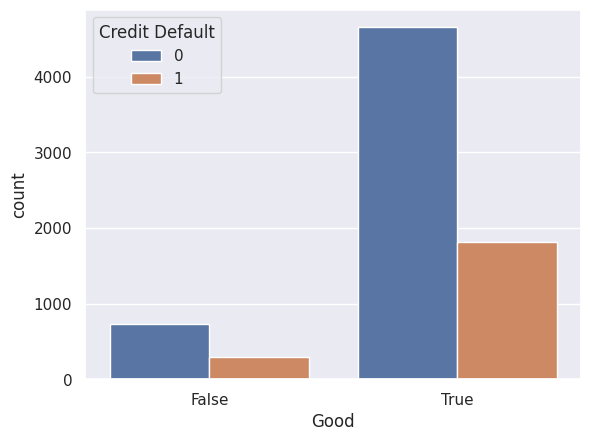

In [251]:
sns.countplot(x="Good", hue='Credit Default', data=df)
plt.show()

In [252]:
df['Credit Default'].value_counts()#Обзор целевой переменной. Credit Default

0    5387
1    2113
Name: Credit Default, dtype: int64

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Home Ownership                     7500 non-null   object 
 1   Annual Income                      7500 non-null   float64
 2   Years in current job               7500 non-null   float64
 3   Tax Liens                          7500 non-null   float64
 4   Number of Open Accounts            7500 non-null   float64
 5   Years of Credit History            7500 non-null   float64
 6   Maximum Open Credit                7500 non-null   float64
 7   Number of Credit Problems          7500 non-null   float64
 8   Months since last delinquent       7500 non-null   float64
 9   Bankruptcies                       7500 non-null   float64
 10  Purpose                            7500 non-null   float64
 11  Term                               7500 non-null   float

In [254]:
# переделываем Purpose во FLOAT



df['Purpose'] = df['Purpose'].astype(float)
df_test['Purpose'] = df_test['Purpose'].astype(float)

In [255]:
COL_SELECTED = [

    
    
        'Current Loan Amount BIG',

        'Good',
        'Annual Income',
        'Years in current job',

        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
        'Purpose',
        'Term',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
    
        'Home Ownership_Have Mortgage',
        'Home Ownership_Home Mortgage',
        'Home Ownership_Own Home',
        'Home Ownership_Rent']

In [256]:
# выбираем числовые столбцы 

COL_SELECTED_NUM = [
        'Annual Income',
        'Years in current job',
        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
                         ]

Annual Income
MannwhitneyuResult(statistic=9386653.0, pvalue=0.9256894005301767)


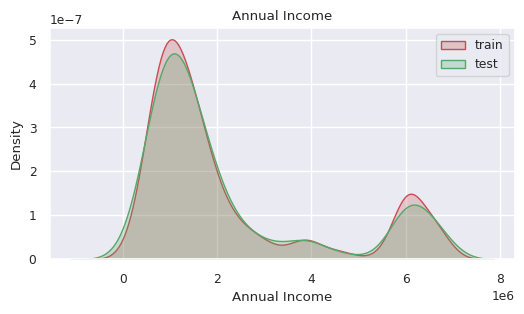

Years in current job
MannwhitneyuResult(statistic=9424506.5, pvalue=0.6869539783622054)


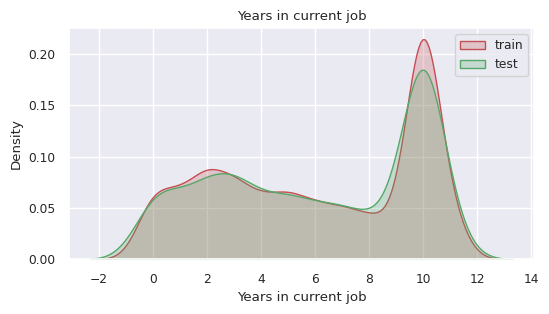

Number of Open Accounts
MannwhitneyuResult(statistic=9110102.5, pvalue=0.033160759360602116)


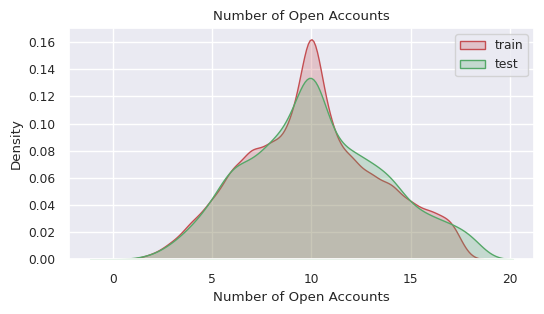

Years of Credit History
MannwhitneyuResult(statistic=9371339.0, pvalue=0.9766367483578579)


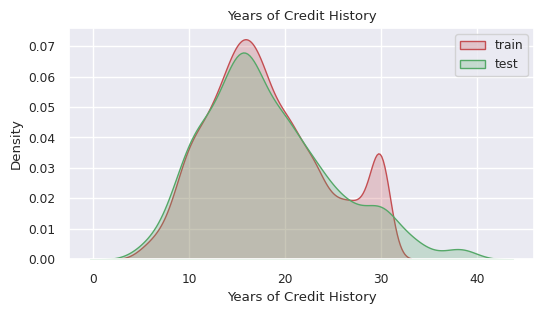

Maximum Open Credit
MannwhitneyuResult(statistic=9438926.5, pvalue=0.6090048663447776)


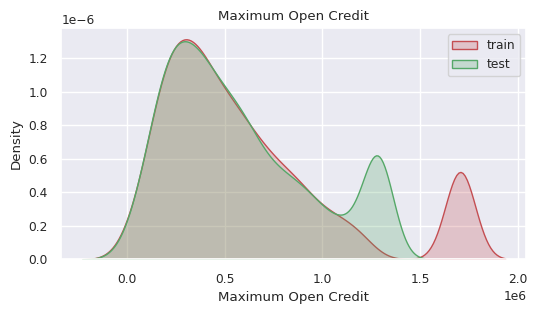

Current Loan Amount
MannwhitneyuResult(statistic=9074421.5, pvalue=0.016157982300107374)


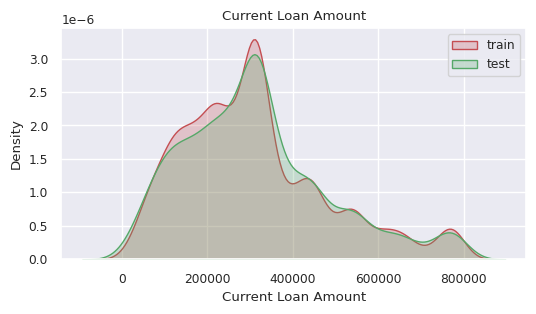

Current Credit Balance
MannwhitneyuResult(statistic=9516103.0, pvalue=0.2588933134132838)


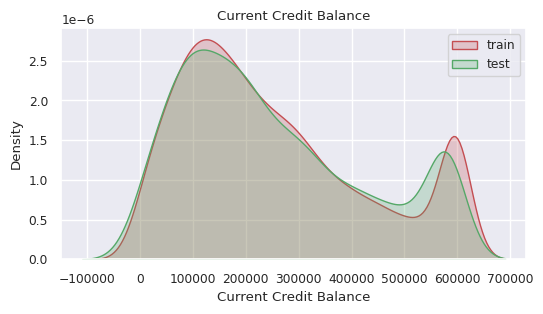

Monthly Debt
MannwhitneyuResult(statistic=9285486.0, pvalue=0.4739466712459831)


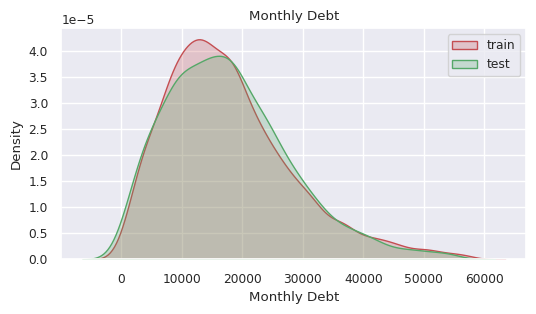

Credit Score
MannwhitneyuResult(statistic=9331092.5, pvalue=0.7062532996600617)


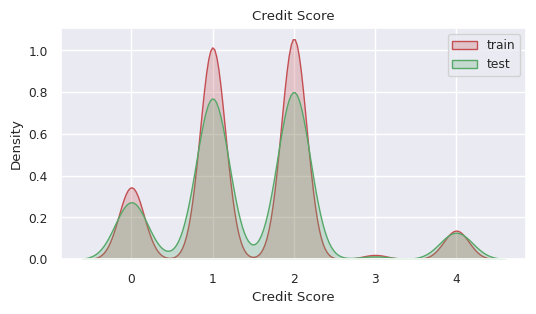

In [257]:
# смотрим похоже-ли распределение непрерывных показателей на train и test

from scipy.stats import mannwhitneyu

# p > 5% - распределения похожи
figsize = (6, 3)
for col in COL_SELECTED_NUM:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

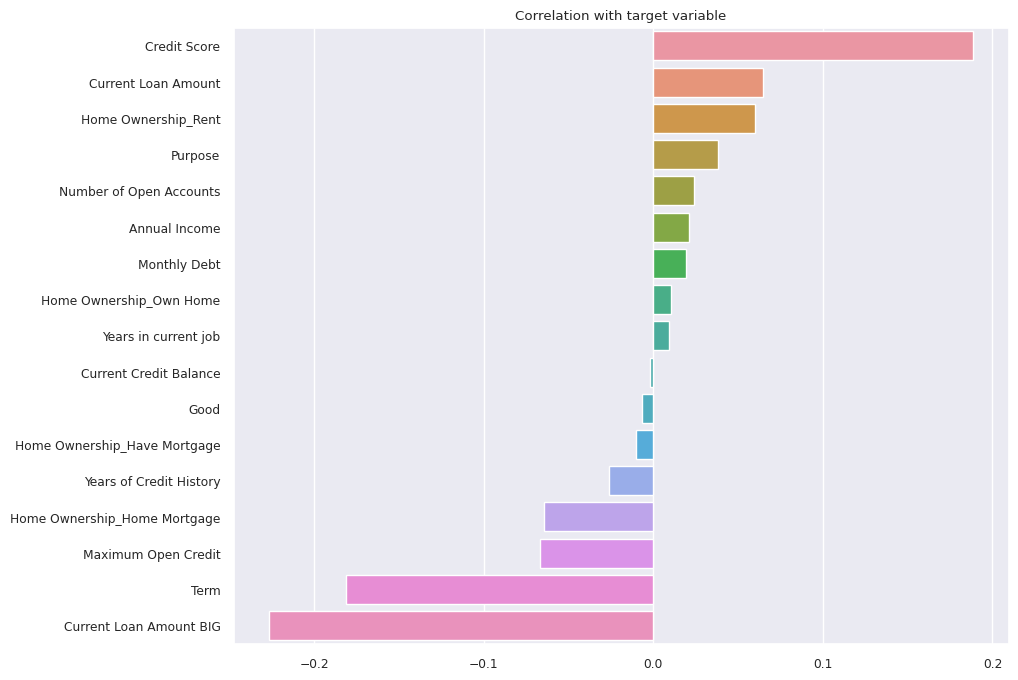

In [258]:
# смотрим влияния столбцов на целевой признак

corr_with_target = df[COL_SELECTED + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

In [259]:
def cor_plot(data, method):## матрица корреляции
    plt.figure(figsize = (14,14))

    sns.set(font_scale=1)
    sns.heatmap(data.corr(method).round(2), annot=True, linewidths=.5, cmap='coolwarm')
    plt.title('Матрица корреляций');

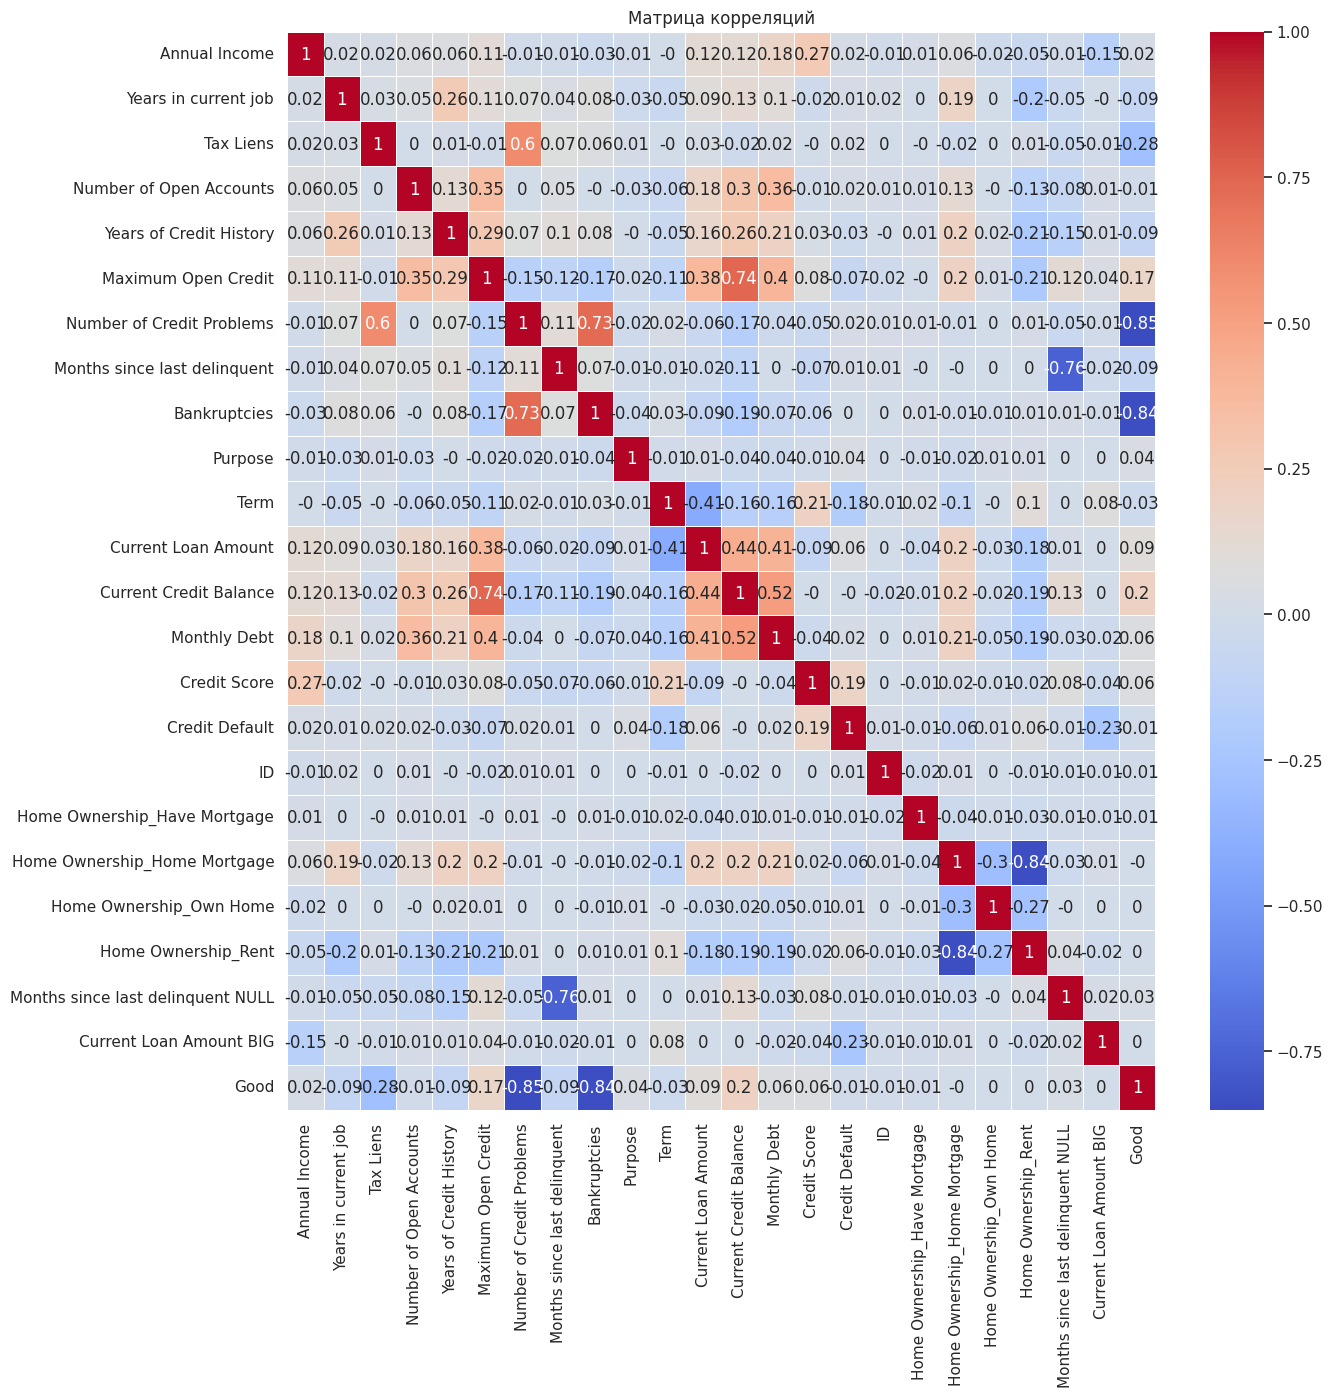

In [260]:
cor_plot(data=df, method='pearson');

In [261]:
X = df[COL_SELECTED]#Разбиение на train и test
y = df['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,

                                                    test_size=0.30, 
                                                    random_state=21)

In [262]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [263]:
target_name='Credit Default'

In [264]:
 balance_df_by_target(df, target_name)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Months since last delinquent NULL,Current Loan Amount BIG,Good
7433,Rent,2011758.0,0.0,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,...,4.0,1,7433,0,0,0,1,False,False,True
2866,Rent,1128961.0,8.0,0.0,8.0,30.0,720192.0,0.0,0.0,0.0,...,2.0,1,2866,0,0,0,1,True,False,True
6382,Rent,457558.0,11.0,0.0,5.0,13.5,614042.0,0.0,0.0,0.0,...,3.0,0,6382,0,0,0,1,True,True,True
1127,Home Mortgage,1373054.0,10.0,0.0,10.0,16.2,773300.0,0.0,0.0,0.0,...,1.0,0,1127,0,1,0,0,True,False,True
5263,Home Mortgage,2440113.0,10.0,0.0,13.0,16.4,636614.0,0.0,8.0,0.0,...,1.0,0,5263,0,1,0,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7217,Own Home,1225747.0,10.0,0.0,7.0,24.6,205304.0,1.0,50.0,1.0,...,1.0,0,7217,0,0,1,0,False,False,False
1729,Home Mortgage,1567196.0,4.0,0.0,12.0,14.1,944306.0,0.0,0.0,0.0,...,2.0,0,1729,0,1,0,0,True,False,True
1422,Rent,6029954.0,3.0,0.0,10.0,8.6,561528.0,0.0,0.0,0.0,...,2.0,1,1422,0,0,0,1,True,False,True
7408,Rent,861327.0,10.0,0.0,7.0,15.7,335984.0,0.0,0.0,0.0,...,2.0,0,7408,0,0,0,1,True,False,True


In [265]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
df_balanced['Credit Default'].value_counts()


0    3771
1    2958
Name: Credit Default, dtype: int64

In [266]:
X_train = df_balanced.drop(columns='Credit Default')
y_train = df_balanced['Credit Default']

# Обучение на моделях

In [267]:
def pred_model(model):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    print(model, '  --  ', f1_score(y_test, y_test_pred))

In [268]:
for model in [
#             Логистическая регрессия
            LogisticRegression(C = 0.1, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50),     
            xgb.XGBClassifier(eval_metric="logloss", max_depth=50, reg_lambda=1, random_state=21),
            KNeighborsClassifier(), # К-ближайших соседей
        
            RandomForestClassifier(), # Случайный лес    
#             Дерево решений
            DecisionTreeClassifier(random_state=21, class_weight={0:1, 1:3.3}, max_depth=4),
            lgbm.LGBMClassifier(class_weight={0:1, 1:3.3}, random_state=21),
            catb.CatBoostClassifier(class_weights=[1, 3.3], silent=True),
            AdaBoostClassifier(),    
            SVC(C=0.05, kernel='rbf'), # Метод опорных векторов
            GaussianNB(),
            ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced'),
            GradientBoostingClassifier(learning_rate=7, random_state=42), # Бустинг
            Perceptron(class_weight='balanced')    
]:
        pred_model(model)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=50, penalty='l1',
                   solver='liblinear')   --   0.49757869249394665
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=21, ...)   --   0.453382084095064
KNeighborsClassifier()   --   0.35805243445692886
RandomForestClassifier()   -

# Логистическая регрессия

In [269]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):#Отчёт по оценке модели
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [270]:
lr = LogisticRegression(penalty='l2',
                       tol=1e-8, #критерий останова
                        C=1e-2, #немножко регуляризации
                       class_weight='balanced', 
                       random_state=43,
                       max_iter=400, #количество итераций
                       n_jobs=-1,
                      )

In [271]:
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.39      0.48      3771
           1       0.48      0.71      0.57      2958

    accuracy                           0.53      6729
   macro avg       0.56      0.55      0.53      6729
weighted avg       0.57      0.53      0.52      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.40      0.52      1616
           1       0.31      0.70      0.43       634

    accuracy                           0.48      2250
   macro avg       0.54      0.55      0.48      2250
weighted avg       0.64      0.48      0.50      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               639  977
1               191  443


In [272]:
#'XGBoost'
model_xgb =xgb.XGBClassifier (eval_metric="logloss", use_label_encoder=False, random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3771
           1       0.98      0.96      0.97      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.97      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1616
           1       0.51      0.45      0.47       634

    accuracy                           0.72      2250
   macro avg       0.65      0.64      0.64      2250
weighted avg       0.71      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1339  277
1                351  283


In [273]:
#модель ближайших соседей

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      3771
           1       0.73      0.65      0.69      2958

    accuracy                           0.74      6729
   macro avg       0.74      0.73      0.73      6729
weighted avg       0.74      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      1616
           1       0.34      0.38      0.36       634

    accuracy                           0.62      2250
   macro avg       0.54      0.55      0.54      2250
weighted avg       0.63      0.62      0.62      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1154  462
1                395  239


In [274]:
#модель CatBoost  

model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3771
           1       0.94      0.85      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.92      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1616
           1       0.55      0.46      0.50       634

    accuracy                           0.74      2250
   macro avg       0.67      0.66      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1373  243
1                340  294


In [275]:
# отдельно модель CatBoost

model_catb = catb.CatBoostClassifier(class_weights=[1, 3.3],
                                    depth=3,
                                    iterations=400, 

                                    silent=True, 

                                    )



model_catb.fit(X_train, y_train)


y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

print('CatBoost:: ')
print(f1_score(y_test, y_test_pred))


CatBoost:: 
0.4987531172069826


In [276]:
#  сохраняем результат


df_test["Credit Default"] = model_catb.predict(df_test[COL_SELECTED])


df_test['ID'] = df_test.index.tolist()
df_test['ID'] = df_test['ID']
df_test1 = df_test[['Credit Default', 'ID']]

df_test1.to_csv(r'ISBosaia_predictions.csv', index=False)